In [17]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [18]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   padova
   2   napoli
   3   gorizia
   4   verbania
   5   prato
   6   carbonia
   7   siracusa
   8   ragusa
   9   potenza
   10   arezzo
   11   sondrio
   12   teramo
   13   reggio_di_calabria
   14   belluno
   15   bolzano
   16   frosinone
   17   modena
   18   pescara
   19   avellino
   20   rieti
   21   bari
   22   salerno
   23   bologna
   24   pesaro
   25   genova
   26   asti
   27   rimini
   28   grosseto
   29   palermo
   30   savona
   31   vercelli
   32   ascoli_piceno
   33   livorno
   34   terni
   35   catanzaro
   36   verona
   37   ravenna
   38   como
   39   pistoia
   40   fermo
   41   caserta
   42   cuneo
   43   crotone
   44   rovigo
   45   brindisi
   46   vicenza
   47   l_aquila
   48   ferrara
   49   sassari
   50   milano
   51   varese
   52   macerata
   53   pisa
   54   enna
   55   agrigento
   56   siena
   57   piacenza
   58   benevento
   59   orist

In [19]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 padova
2 napoli
3 gorizia
4 verbania
5 prato
6 siracusa
7 ragusa
8 potenza
9 arezzo
10 sondrio
11 teramo
12 reggio_di_calabria
13 belluno
14 bolzano
15 frosinone
16 modena
17 pescara
18 avellino
19 rieti
20 bari
21 salerno
22 bologna
23 pesaro
24 genova
25 asti
26 rimini
27 grosseto
28 palermo
29 savona
30 vercelli
31 ascoli_piceno
32 livorno
33 terni
34 catanzaro
35 verona
36 ravenna
37 como
38 pistoia
39 fermo
40 caserta
41 cuneo
42 crotone
43 rovigo
44 brindisi
45 vicenza
46 l_aquila
47 ferrara
48 sassari
49 milano
50 varese
51 macerata
52 pisa
53 enna
54 agrigento
55 siena
56 piacenza
57 benevento
58 oristano
59 massa
60 vibo_valentia
61 reggio_nell_emilia
62 mantova
63 parma
64 caltanissetta
65 ancona
66 cagliari
67 matera
68 lecco
69 catania
70 bergamo
71 nuoro
72 novara
73 biella
74 monza
75 messina
76 viterbo
77 firenze
78 torino
79 brescia
80 taranto
81 cosenza
82 bat
83 imperia
84 alessandria
85 foggia
86 trieste
87 trapani
88 roma
89 lecce
90 perugia
91 trento
92 chieti
93

In [20]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [21]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

In [22]:
feats_innet_to_visualnamemap = {"density" : "Density",
                                "commutersdensity" : "Com. Density",                          
                                "depriv" : "Depriv. Index",
                                "lat" : "Latitude",
                                "Ratio0200ver65" : "Old Young Ratio",
                                "avg_wpm10_period1_2020" : "Avg. PM10",
                                "avg_wno_period1_2020" : "Avg. NO",
                                "avg_wpans_period1_2020" : "Avg. PANS",
                                "avg_wso2_period1_2020" : "Avg. SO2",
                                "randomfeature" : "Random Feat."}

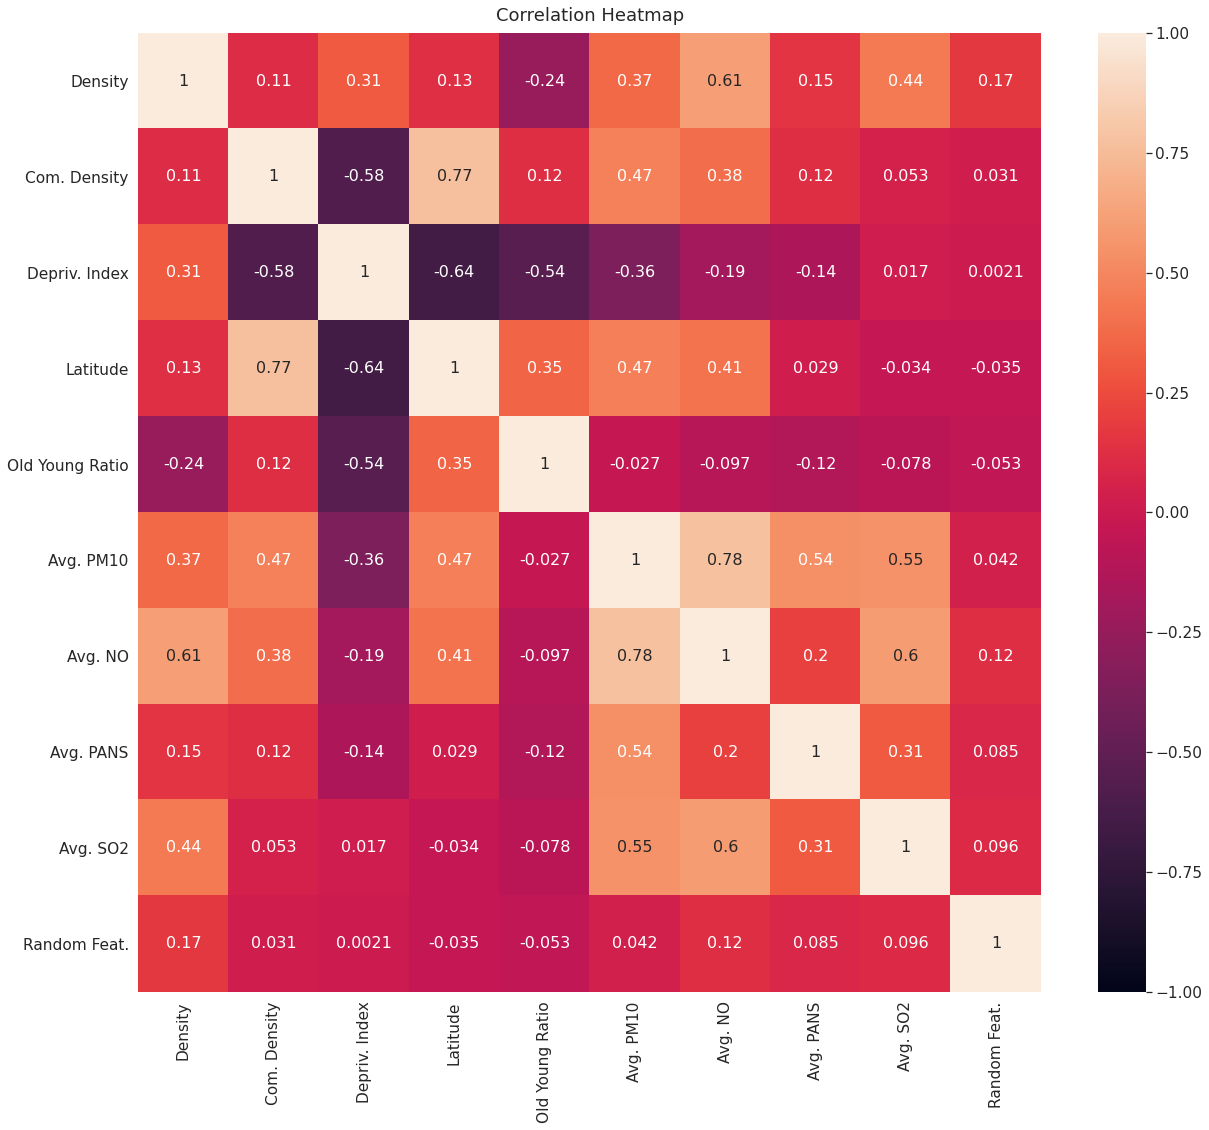

In [23]:
import seaborn as sns

featuresused = features

evaluatecorrelation = {}

for v in featuresused:
    vname = feats_innet_to_visualnamemap[v]
    evaluatecorrelation[vname] = features_dict[v]

plt.figure(figsize=(18, 16))
features_df = pd.DataFrame.from_dict(evaluatecorrelation)

sns.set(font_scale=1.4)
heatmap = sns.heatmap(features_df.corr(),vmin=-1, vmax=1, annot=True , annot_kws={"size": 16});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

figure = heatmap.get_figure()    
figure.subplots_adjust()
figure.tight_layout()
figure.savefig('heatmap.png',  bbox_inches="tight", pad_inches=0.5)


Grid Search to optimize the RMSE on the Full Set

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.34247  0.02206 
    Test set average RMSE:  0.96694  0.09950 

Prediction STD :    1.29854
True value STD :    1.47826
Difference in percentage:   12.15777

             Fullset RMSE:    0.33767
                       R2:    0.94782


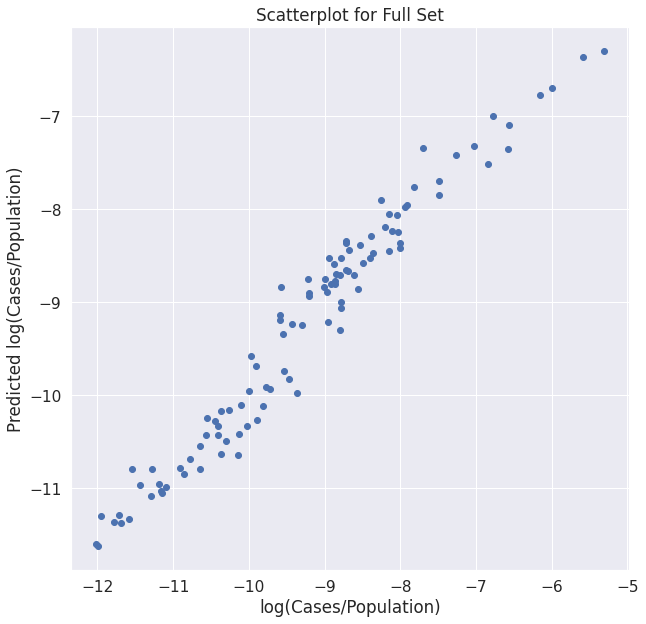

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.06298 +/- 0.00675
Feature:                   Com. Density, Score: 0.24245 +/- 0.04479
Feature:                  Depriv. Index, Score: 0.12131 +/- 0.01687
Feature:                       Latitude, Score: 0.88017 +/- 0.11030
Feature:                Old Young Ratio, Score: 0.11854 +/- 0.01820
Feature:                      Avg. PM10, Score: 0.21065 +/- 0.03007
Feature:                        Avg. NO, Score: 0.19509 +/- 0.02559
Feature:                       Avg. SO2, Score: 0.07691 +/- 0.01034


<Figure size 432x288 with 0 Axes>

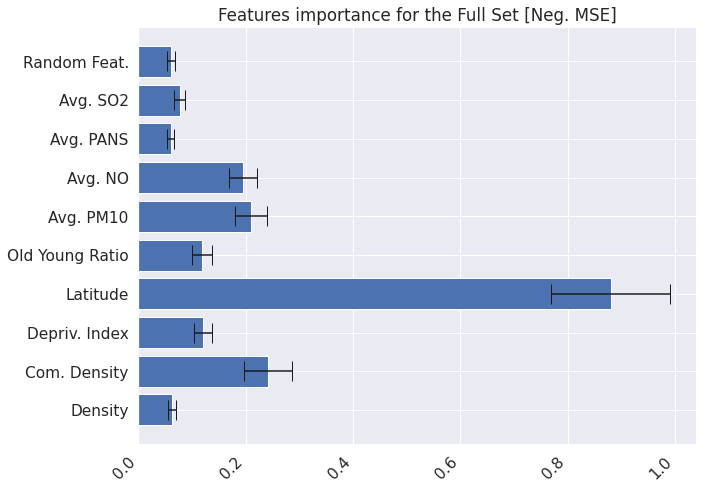

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.02882 +/- 0.00309
Feature:                   Com. Density, Score: 0.11095 +/- 0.02050
Feature:                  Depriv. Index, Score: 0.05552 +/- 0.00772
Feature:                       Latitude, Score: 0.40278 +/- 0.05048
Feature:                Old Young Ratio, Score: 0.05425 +/- 0.00833
Feature:                      Avg. PM10, Score: 0.09640 +/- 0.01376
Feature:                        Avg. NO, Score: 0.08928 +/- 0.01171
Feature:                       Avg. SO2, Score: 0.03520 +/- 0.00473


<Figure size 432x288 with 0 Axes>

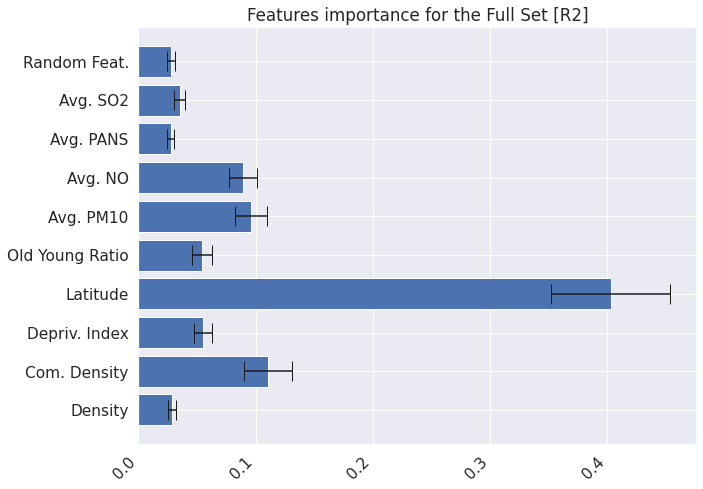

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.33713
                       R2:    0.94865


<Figure size 432x288 with 0 Axes>

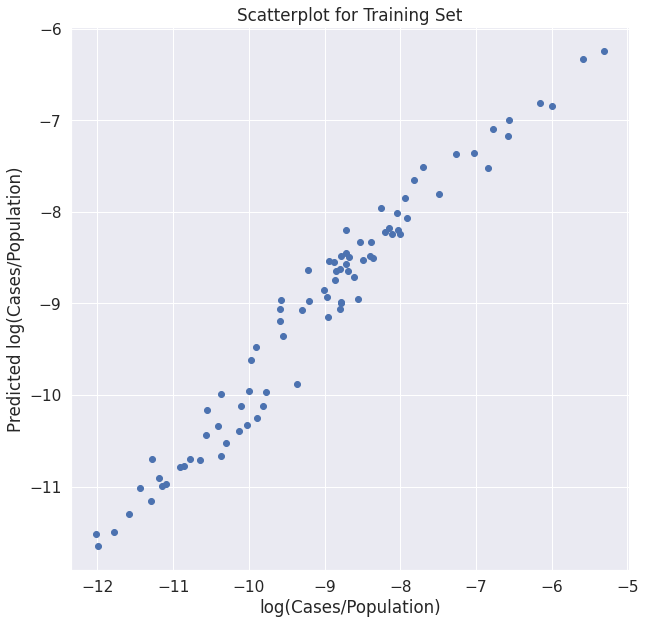

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.06738
                       R2:    0.27016


<Figure size 432x288 with 0 Axes>

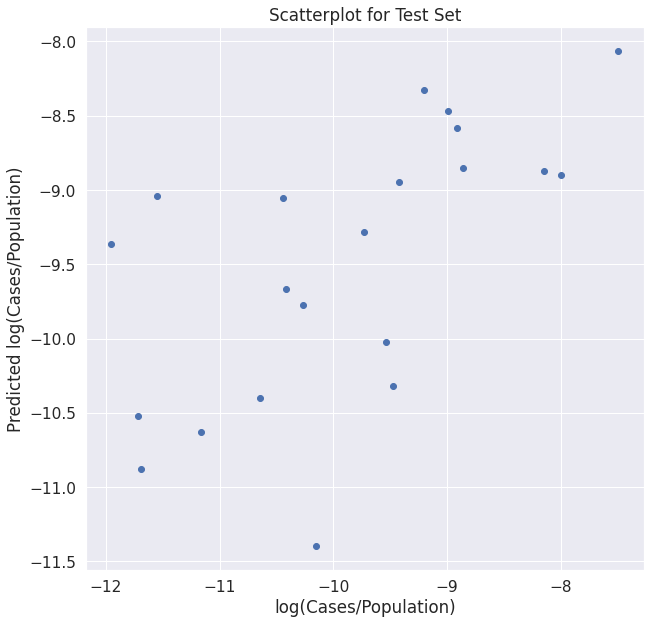

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00808 +/- 0.02769
Feature:                   Com. Density, Score: 0.08904 +/- 0.15133
Feature:                  Depriv. Index, Score: 0.00748 +/- 0.04651
Feature:                       Latitude, Score: 0.36731 +/- 0.18302
Feature:                Old Young Ratio, Score: 0.01584 +/- 0.02306
Feature:                      Avg. PM10, Score: 0.01717 +/- 0.05621
Feature:                        Avg. NO, Score: 0.03395 +/- 0.04705
Feature:                       Avg. SO2, Score: 0.04868 +/- 0.02527


<Figure size 432x288 with 0 Axes>

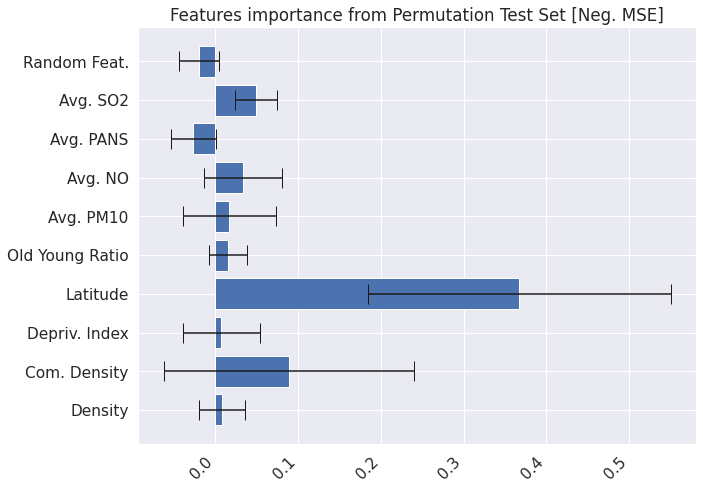

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.00518 +/- 0.01774
Feature:                   Com. Density, Score: 0.05704 +/- 0.09695
Feature:                  Depriv. Index, Score: 0.00479 +/- 0.02979
Feature:                       Latitude, Score: 0.23530 +/- 0.11724
Feature:                Old Young Ratio, Score: 0.01015 +/- 0.01477
Feature:                      Avg. PM10, Score: 0.01100 +/- 0.03601
Feature:                        Avg. NO, Score: 0.02175 +/- 0.03014
Feature:                       Avg. SO2, Score: 0.03119 +/- 0.01619


<Figure size 432x288 with 0 Axes>

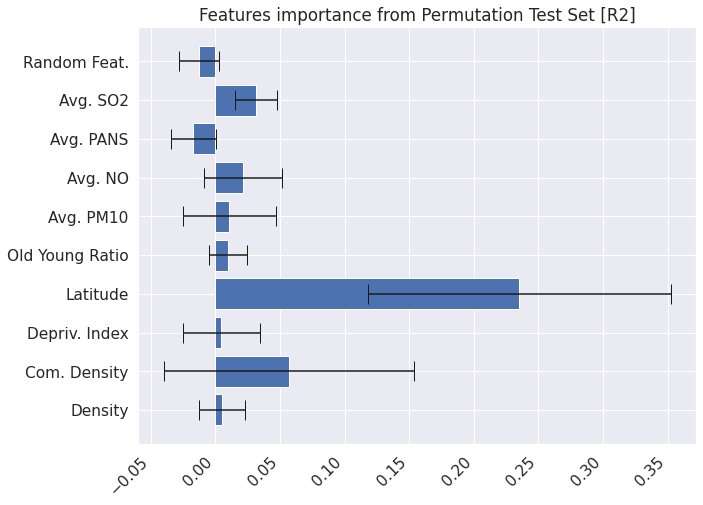

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.39482 +/- 0.05318
Feature:                  Depriv. Index, Score: 0.12517 +/- 0.01925
Feature:                       Latitude, Score: 0.67833 +/- 0.09158
Feature:                Old Young Ratio, Score: 0.10970 +/- 0.01977
Feature:                      Avg. PM10, Score: 0.18871 +/- 0.02363
Feature:                        Avg. NO, Score: 0.14682 +/- 0.01642
Feature:                       Avg. SO2, Score: 0.07989 +/- 0.00866


<Figure size 432x288 with 0 Axes>

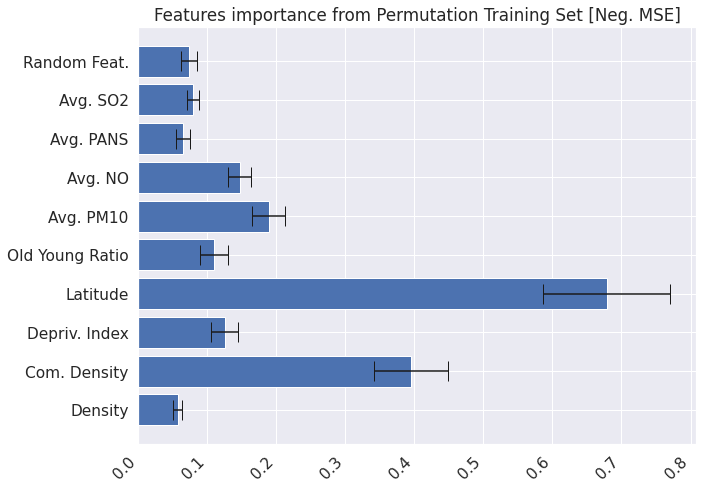

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.17837 +/- 0.02402
Feature:                  Depriv. Index, Score: 0.05655 +/- 0.00870
Feature:                       Latitude, Score: 0.30645 +/- 0.04137
Feature:                Old Young Ratio, Score: 0.04956 +/- 0.00893
Feature:                      Avg. PM10, Score: 0.08525 +/- 0.01067
Feature:                        Avg. NO, Score: 0.06633 +/- 0.00742
Feature:                       Avg. SO2, Score: 0.03609 +/- 0.00391


<Figure size 432x288 with 0 Axes>

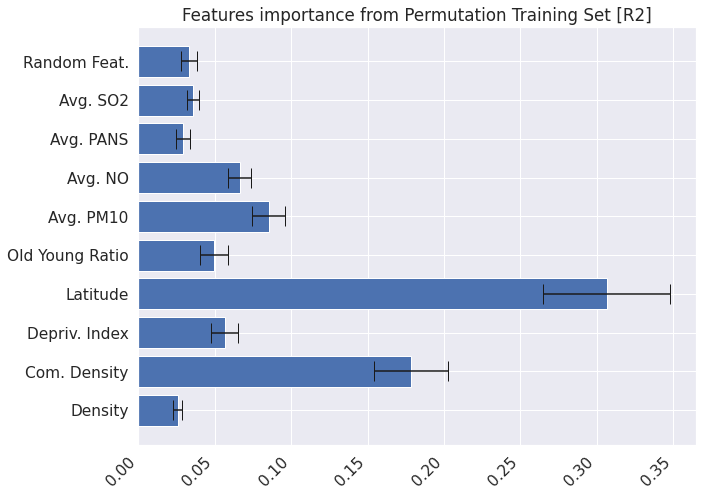

<Figure size 720x720 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.36984  0.02130 
    Test set average RMSE:  1.03687  0.10335 

Prediction STD :    1.26182
True value STD :    1.47826
Difference in percentage:   14.64118

             Fullset RMSE:    0.36220
                       R2:    0.93997


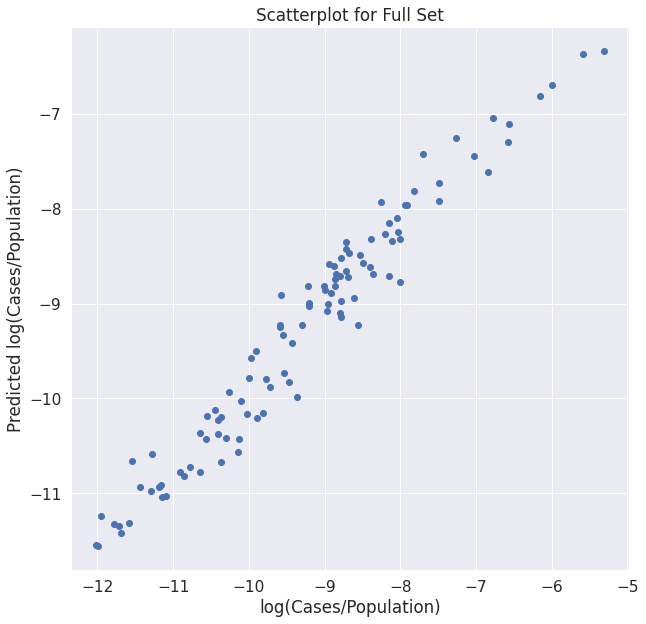

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.62527 +/- 0.09589
Feature:                  Depriv. Index, Score: 0.26716 +/- 0.03635
Feature:                Old Young Ratio, Score: 0.15947 +/- 0.02204
Feature:                      Avg. PM10, Score: 0.31217 +/- 0.04691
Feature:                        Avg. NO, Score: 0.35987 +/- 0.04504
Feature:                      Avg. PANS, Score: 0.08690 +/- 0.01116
Feature:                       Avg. SO2, Score: 0.12468 +/- 0.01444


<Figure size 432x288 with 0 Axes>

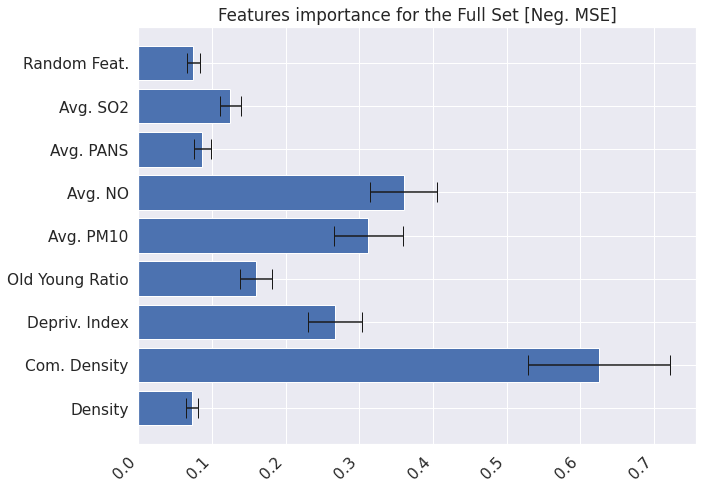

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                   Com. Density, Score: 0.28613 +/- 0.04388
Feature:                  Depriv. Index, Score: 0.12225 +/- 0.01664
Feature:                Old Young Ratio, Score: 0.07298 +/- 0.01009
Feature:                      Avg. PM10, Score: 0.14285 +/- 0.02147
Feature:                        Avg. NO, Score: 0.16468 +/- 0.02061
Feature:                      Avg. PANS, Score: 0.03977 +/- 0.00511
Feature:                       Avg. SO2, Score: 0.05706 +/- 0.00661


<Figure size 432x288 with 0 Axes>

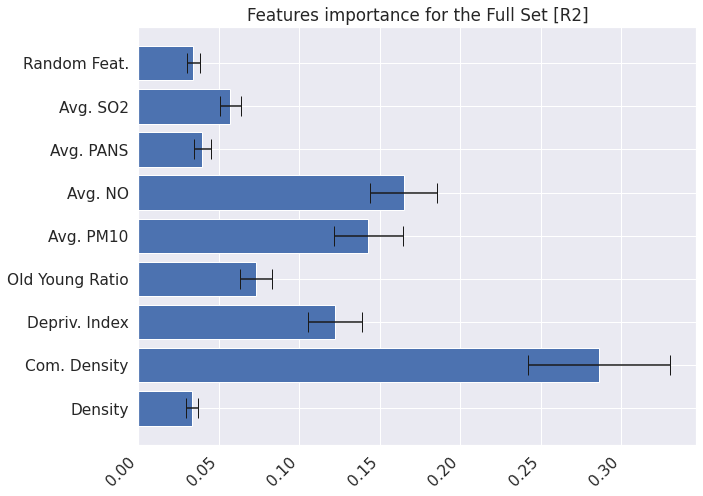

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.35852
                       R2:    0.94193


<Figure size 432x288 with 0 Axes>

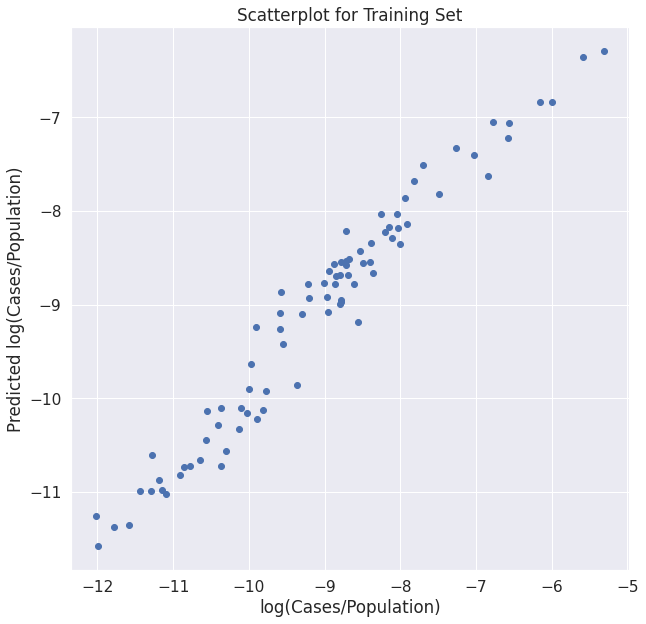

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.13996
                       R2:    0.16752


<Figure size 432x288 with 0 Axes>

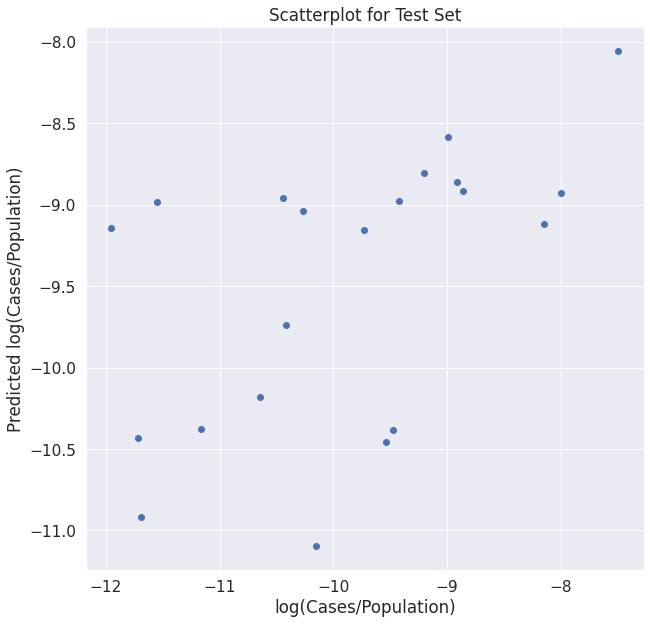

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.41207 +/- 0.27068
Feature:                  Depriv. Index, Score: 0.08816 +/- 0.06610
Feature:                Old Young Ratio, Score: 0.02094 +/- 0.02259
Feature:                      Avg. PM10, Score: 0.06304 +/- 0.07743
Feature:                        Avg. NO, Score: 0.09799 +/- 0.08433
Feature:                       Avg. SO2, Score: 0.09240 +/- 0.05088


<Figure size 432x288 with 0 Axes>

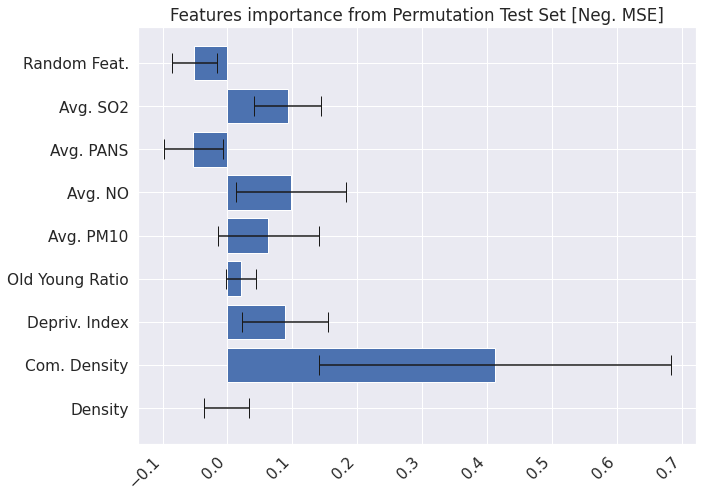

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.26398 +/- 0.17340
Feature:                  Depriv. Index, Score: 0.05647 +/- 0.04234
Feature:                Old Young Ratio, Score: 0.01342 +/- 0.01447
Feature:                      Avg. PM10, Score: 0.04039 +/- 0.04960
Feature:                        Avg. NO, Score: 0.06278 +/- 0.05402
Feature:                       Avg. SO2, Score: 0.05920 +/- 0.03259


<Figure size 432x288 with 0 Axes>

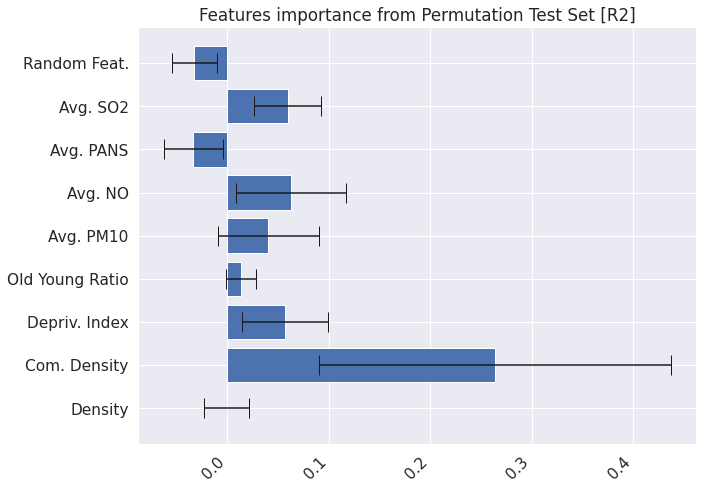

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.83376 +/- 0.10383
Feature:                  Depriv. Index, Score: 0.24083 +/- 0.04094
Feature:                Old Young Ratio, Score: 0.11362 +/- 0.01610
Feature:                      Avg. PM10, Score: 0.28703 +/- 0.03969
Feature:                        Avg. NO, Score: 0.23753 +/- 0.03046
Feature:                      Avg. PANS, Score: 0.10248 +/- 0.01824
Feature:                       Avg. SO2, Score: 0.10793 +/- 0.01119


<Figure size 432x288 with 0 Axes>

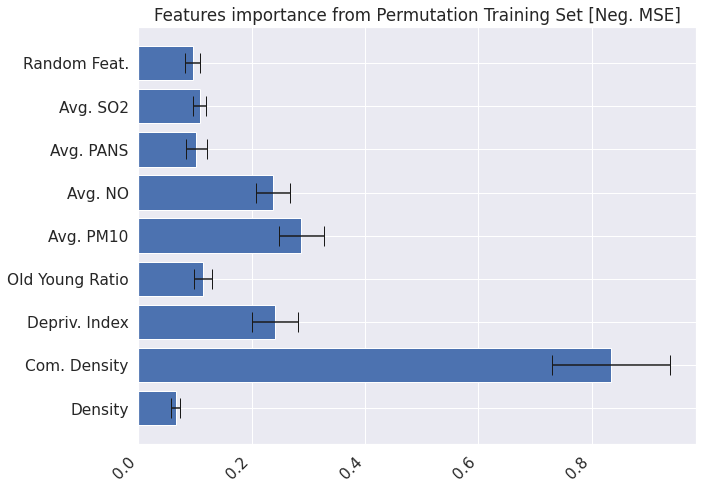

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.37667 +/- 0.04691
Feature:                  Depriv. Index, Score: 0.10880 +/- 0.01849
Feature:                Old Young Ratio, Score: 0.05133 +/- 0.00727
Feature:                      Avg. PM10, Score: 0.12967 +/- 0.01793
Feature:                        Avg. NO, Score: 0.10731 +/- 0.01376
Feature:                      Avg. PANS, Score: 0.04630 +/- 0.00824
Feature:                       Avg. SO2, Score: 0.04876 +/- 0.00506


<Figure size 432x288 with 0 Axes>

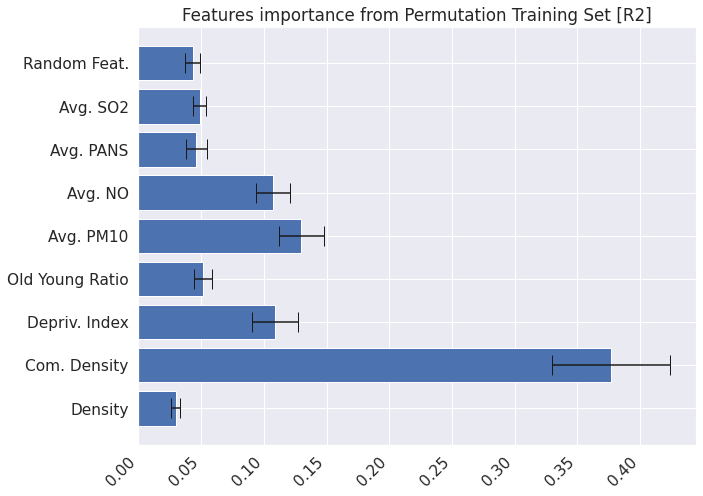

<Figure size 720x720 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_fullset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.38498  0.02492 
    Test set average RMSE:  1.10893  0.10654 

Prediction STD :    1.22100
True value STD :    1.47826
Difference in percentage:   17.40302

             Fullset RMSE:    0.38580
                       R2:    0.93189


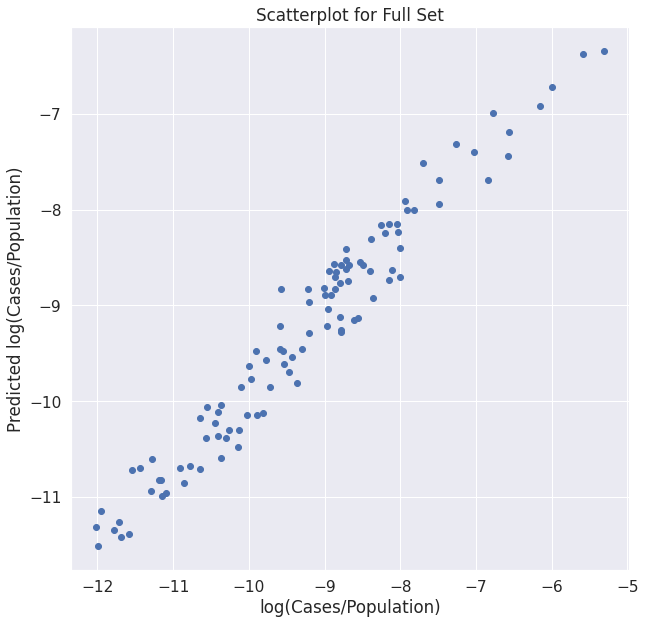

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.13733 +/- 0.01607
Feature:                  Depriv. Index, Score: 0.51661 +/- 0.06704
Feature:                Old Young Ratio, Score: 0.15502 +/- 0.01753
Feature:                      Avg. PM10, Score: 0.47811 +/- 0.06937
Feature:                        Avg. NO, Score: 0.56755 +/- 0.07428
Feature:                      Avg. PANS, Score: 0.14668 +/- 0.01632
Feature:                       Avg. SO2, Score: 0.17332 +/- 0.02035


<Figure size 432x288 with 0 Axes>

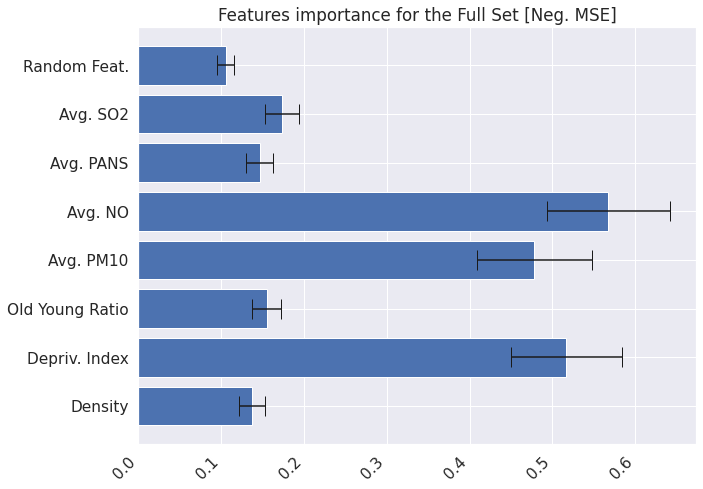

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.06284 +/- 0.00735
Feature:                  Depriv. Index, Score: 0.23641 +/- 0.03068
Feature:                Old Young Ratio, Score: 0.07094 +/- 0.00802
Feature:                      Avg. PM10, Score: 0.21879 +/- 0.03174
Feature:                        Avg. NO, Score: 0.25972 +/- 0.03399
Feature:                      Avg. PANS, Score: 0.06712 +/- 0.00747
Feature:                       Avg. SO2, Score: 0.07931 +/- 0.00931


<Figure size 432x288 with 0 Axes>

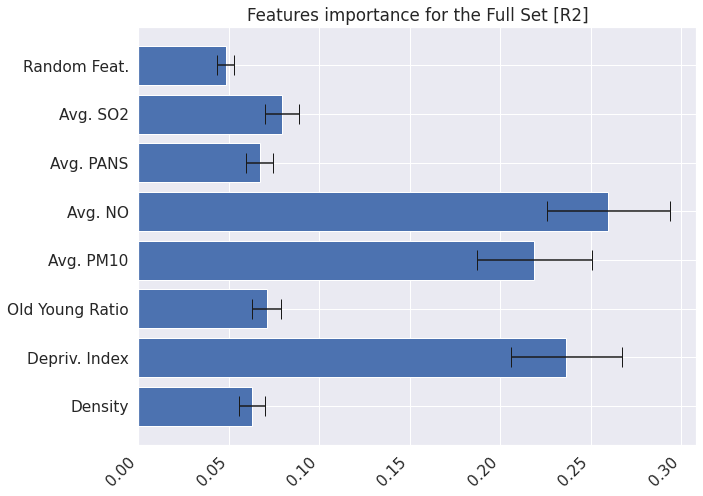

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.38871
                       R2:    0.93174


<Figure size 432x288 with 0 Axes>

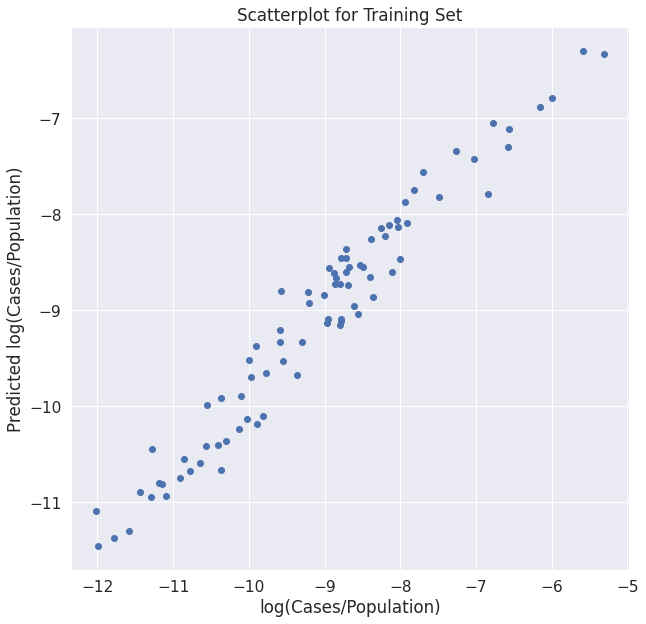

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.04589
                       R2:    0.29925


<Figure size 432x288 with 0 Axes>

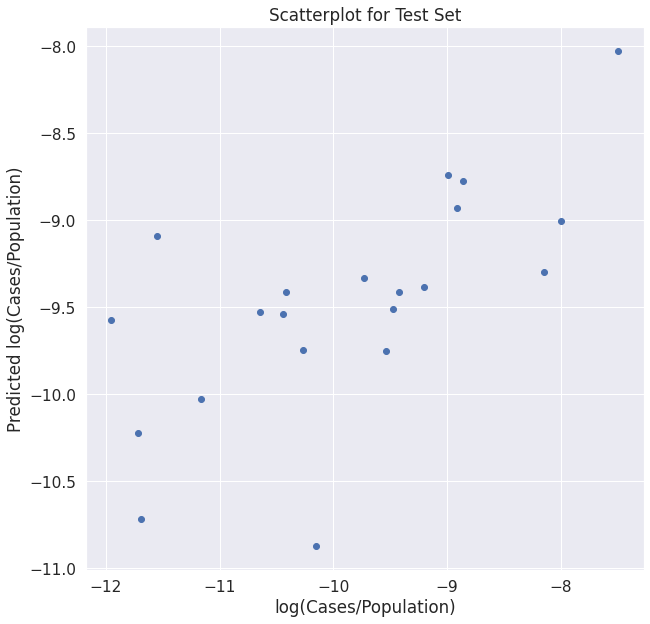

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.06894 +/- 0.04013
Feature:                  Depriv. Index, Score: 0.35059 +/- 0.16122
Feature:                Old Young Ratio, Score: 0.04289 +/- 0.04780
Feature:                      Avg. PM10, Score: 0.13354 +/- 0.08559
Feature:                        Avg. NO, Score: 0.29986 +/- 0.13007
Feature:                       Avg. SO2, Score: 0.09176 +/- 0.03593


<Figure size 432x288 with 0 Axes>

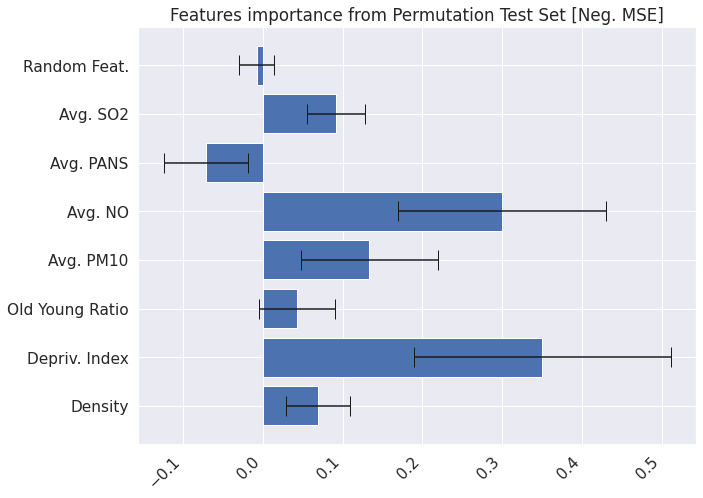

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.04416 +/- 0.02571
Feature:                  Depriv. Index, Score: 0.22459 +/- 0.10328
Feature:                Old Young Ratio, Score: 0.02748 +/- 0.03062
Feature:                      Avg. PM10, Score: 0.08555 +/- 0.05483
Feature:                        Avg. NO, Score: 0.19209 +/- 0.08332
Feature:                       Avg. SO2, Score: 0.05878 +/- 0.02302


<Figure size 432x288 with 0 Axes>

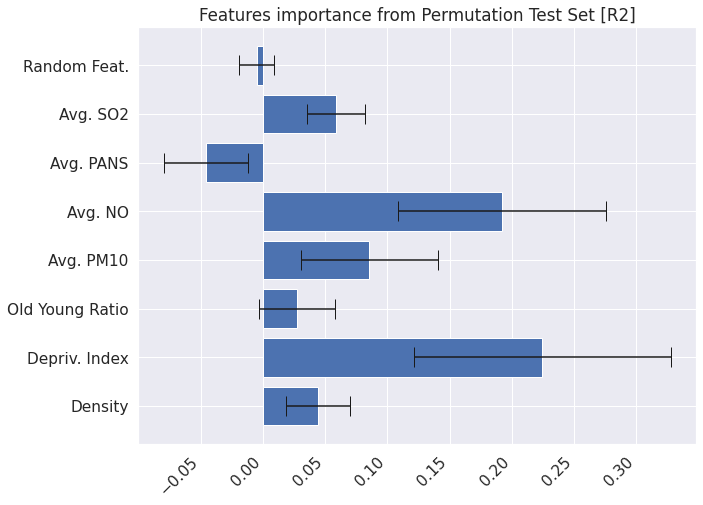

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.63147 +/- 0.08675
Feature:                Old Young Ratio, Score: 0.16824 +/- 0.02188
Feature:                      Avg. PM10, Score: 0.39934 +/- 0.05939
Feature:                        Avg. NO, Score: 0.47374 +/- 0.06458
Feature:                      Avg. PANS, Score: 0.15757 +/- 0.02632
Feature:                       Avg. SO2, Score: 0.14768 +/- 0.01645


<Figure size 432x288 with 0 Axes>

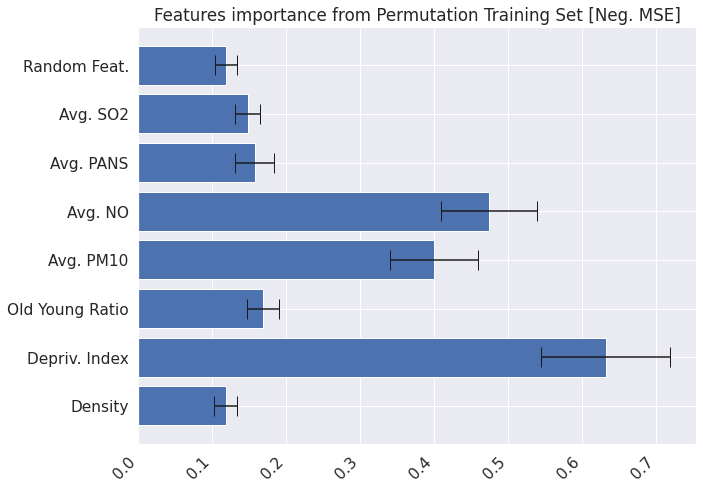

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                  Depriv. Index, Score: 0.28528 +/- 0.03919
Feature:                Old Young Ratio, Score: 0.07601 +/- 0.00989
Feature:                      Avg. PM10, Score: 0.18041 +/- 0.02683
Feature:                        Avg. NO, Score: 0.21402 +/- 0.02918
Feature:                      Avg. PANS, Score: 0.07118 +/- 0.01189
Feature:                       Avg. SO2, Score: 0.06672 +/- 0.00743


<Figure size 432x288 with 0 Axes>

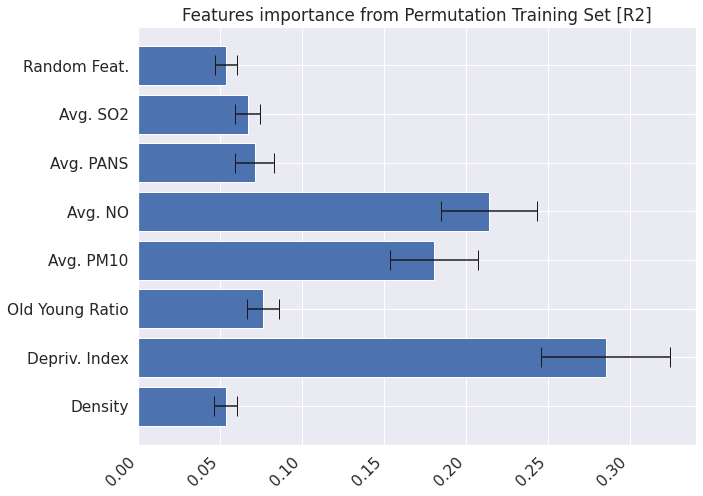

<Figure size 720x720 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse  = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Training Set

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.35811  0.02641 
    Test set average RMSE:  0.94284  0.10232 

Prediction STD :    1.28909
True value STD :    1.47826
Difference in percentage:   12.79649

             Fullset RMSE:    0.34259
                       R2:    0.94629


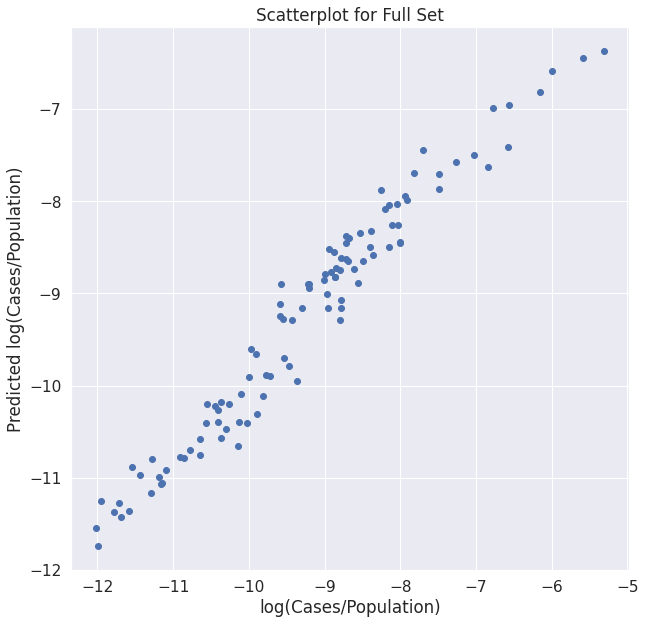

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.28720 +/- 0.04975
Feature:                  Depriv. Index, Score: 0.12007 +/- 0.01766
Feature:                       Latitude, Score: 0.74153 +/- 0.09004
Feature:                Old Young Ratio, Score: 0.13506 +/- 0.02016
Feature:                      Avg. PM10, Score: 0.21498 +/- 0.03060
Feature:                        Avg. NO, Score: 0.20460 +/- 0.02942
Feature:                       Avg. SO2, Score: 0.08785 +/- 0.01116


<Figure size 432x288 with 0 Axes>

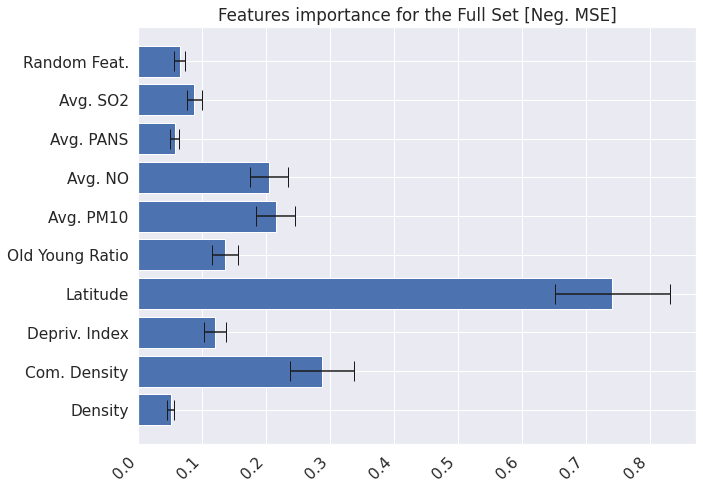

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                   Com. Density, Score: 0.13143 +/- 0.02277
Feature:                  Depriv. Index, Score: 0.05494 +/- 0.00808
Feature:                       Latitude, Score: 0.33934 +/- 0.04121
Feature:                Old Young Ratio, Score: 0.06181 +/- 0.00923
Feature:                      Avg. PM10, Score: 0.09838 +/- 0.01400
Feature:                        Avg. NO, Score: 0.09363 +/- 0.01346
Feature:                       Avg. SO2, Score: 0.04020 +/- 0.00511


<Figure size 432x288 with 0 Axes>

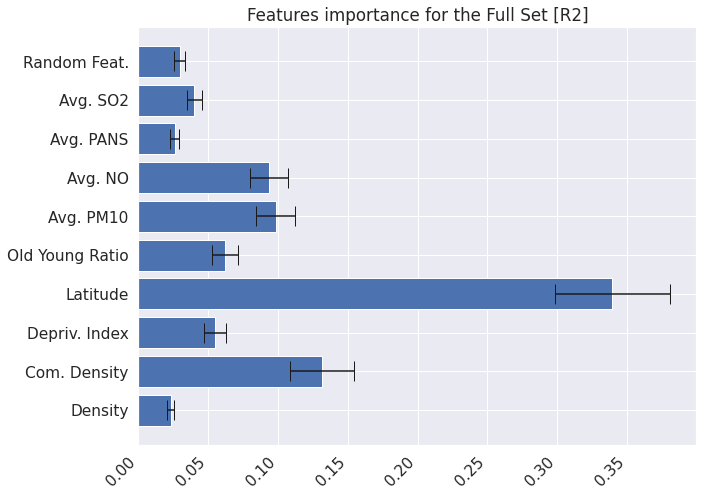

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.33836
                       R2:    0.94828


<Figure size 432x288 with 0 Axes>

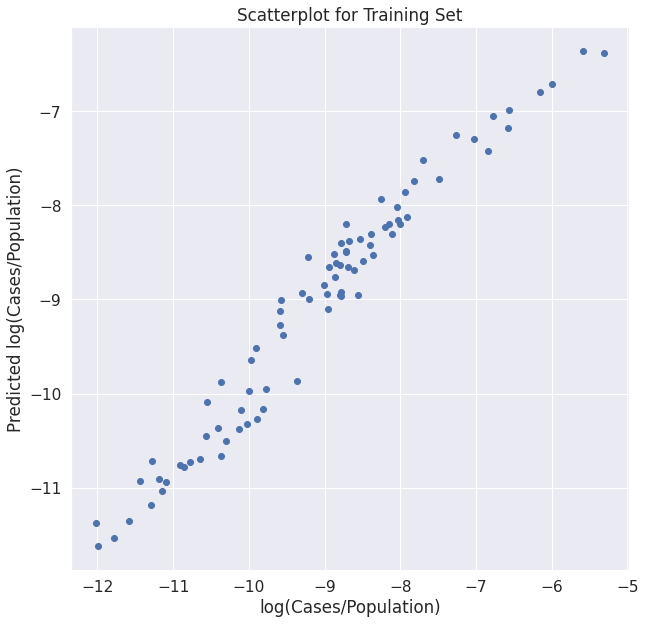

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.09694
                       R2:    0.22917


<Figure size 432x288 with 0 Axes>

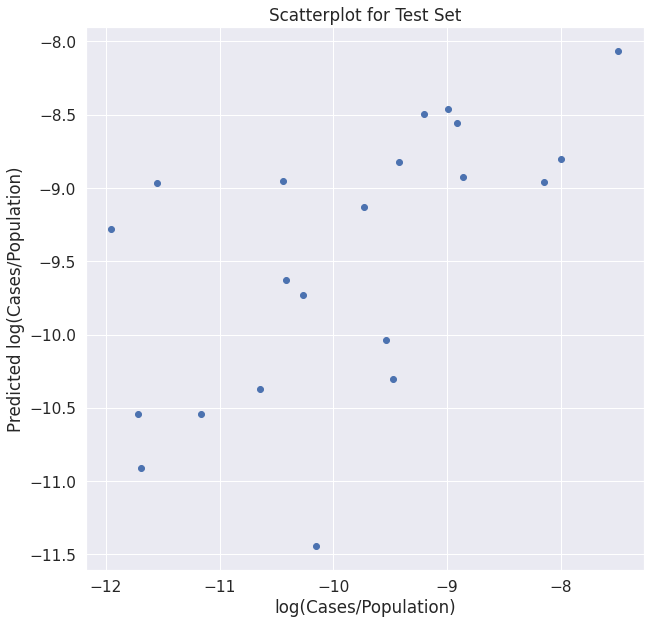

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00985 +/- 0.03306
Feature:                   Com. Density, Score: 0.11569 +/- 0.18045
Feature:                       Latitude, Score: 0.26621 +/- 0.15364
Feature:                Old Young Ratio, Score: 0.02690 +/- 0.02851
Feature:                      Avg. PM10, Score: 0.05022 +/- 0.07294
Feature:                        Avg. NO, Score: 0.03361 +/- 0.04002
Feature:                       Avg. SO2, Score: 0.08398 +/- 0.03914


<Figure size 432x288 with 0 Axes>

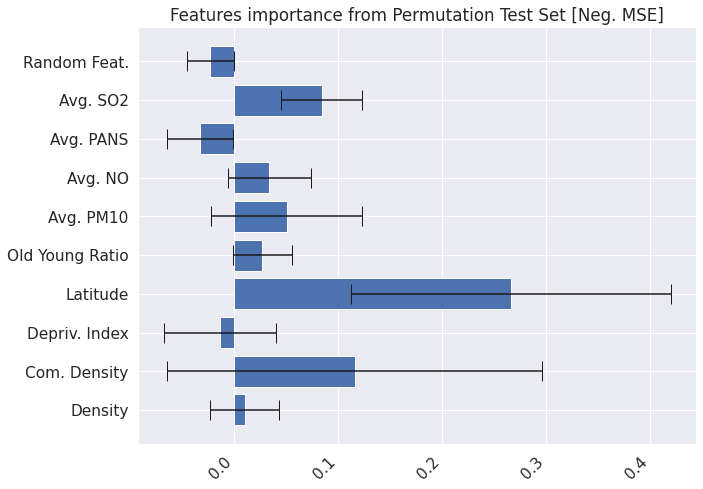

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.00631 +/- 0.02118
Feature:                   Com. Density, Score: 0.07411 +/- 0.11560
Feature:                       Latitude, Score: 0.17054 +/- 0.09843
Feature:                Old Young Ratio, Score: 0.01723 +/- 0.01826
Feature:                      Avg. PM10, Score: 0.03217 +/- 0.04673
Feature:                        Avg. NO, Score: 0.02153 +/- 0.02564
Feature:                       Avg. SO2, Score: 0.05380 +/- 0.02508


<Figure size 432x288 with 0 Axes>

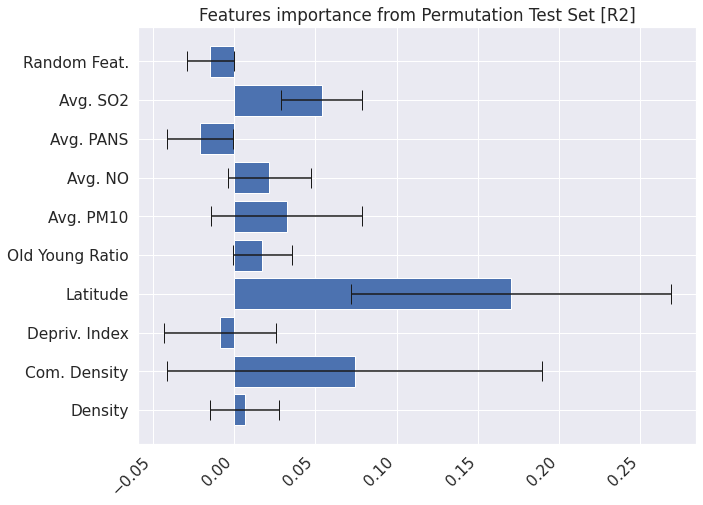

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.47496 +/- 0.06292
Feature:                  Depriv. Index, Score: 0.14465 +/- 0.02318
Feature:                       Latitude, Score: 0.55156 +/- 0.07329
Feature:                Old Young Ratio, Score: 0.10343 +/- 0.01850
Feature:                      Avg. PM10, Score: 0.22583 +/- 0.02959
Feature:                        Avg. NO, Score: 0.12108 +/- 0.01327
Feature:                       Avg. SO2, Score: 0.08282 +/- 0.01037


<Figure size 432x288 with 0 Axes>

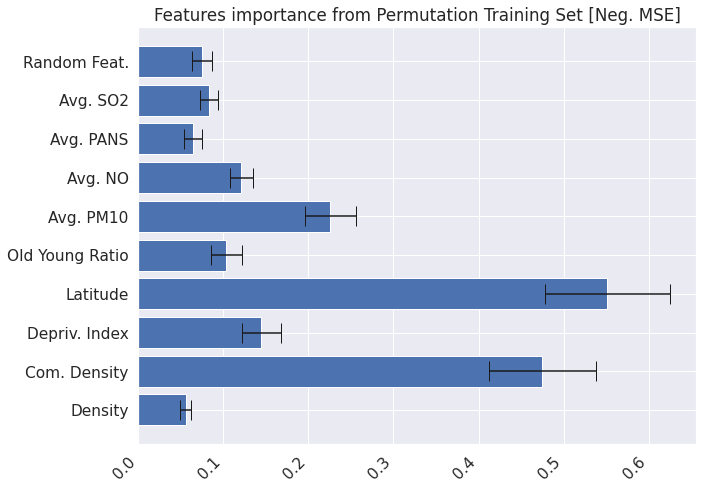

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.21457 +/- 0.02843
Feature:                  Depriv. Index, Score: 0.06535 +/- 0.01047
Feature:                       Latitude, Score: 0.24918 +/- 0.03311
Feature:                Old Young Ratio, Score: 0.04673 +/- 0.00836
Feature:                      Avg. PM10, Score: 0.10202 +/- 0.01337
Feature:                        Avg. NO, Score: 0.05470 +/- 0.00600
Feature:                       Avg. SO2, Score: 0.03742 +/- 0.00469


<Figure size 432x288 with 0 Axes>

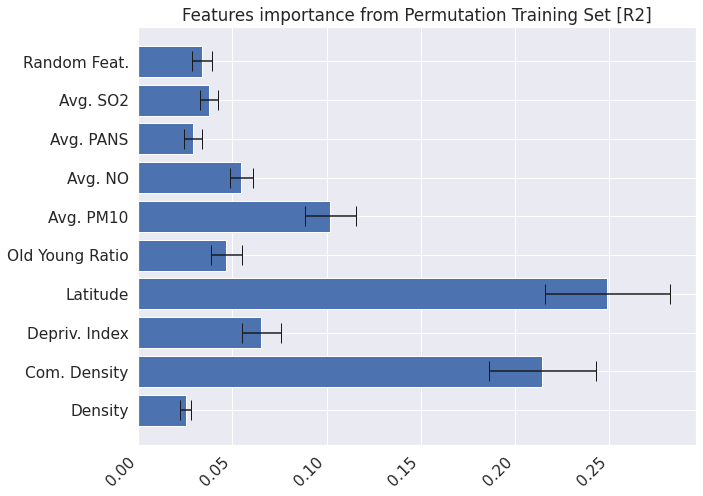

<Figure size 720x720 with 0 Axes>

In [11]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.37395  0.02184 
    Test set average RMSE:  1.01436  0.08894 

Prediction STD :    1.25586
True value STD :    1.47826
Difference in percentage:   15.04497

             Fullset RMSE:    0.36872
                       R2:    0.93779


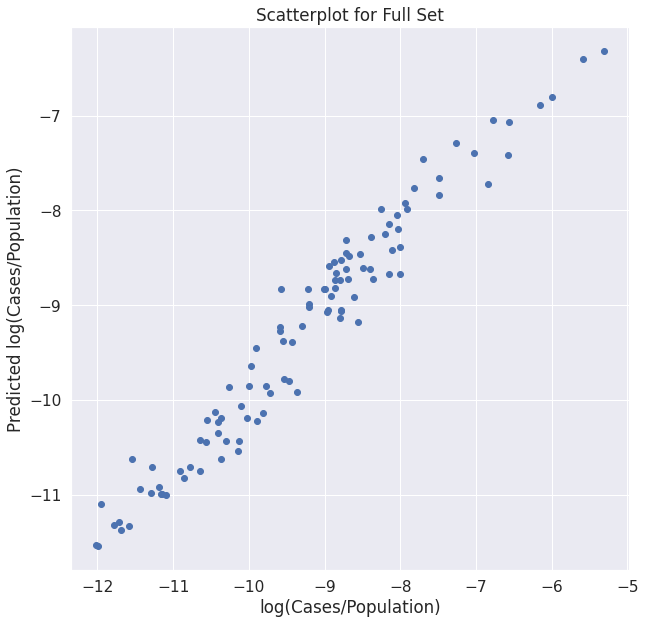

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.08727 +/- 0.00898
Feature:                   Com. Density, Score: 0.70114 +/- 0.10739
Feature:                  Depriv. Index, Score: 0.24360 +/- 0.03268
Feature:                Old Young Ratio, Score: 0.15593 +/- 0.02027
Feature:                      Avg. PM10, Score: 0.27224 +/- 0.04127
Feature:                        Avg. NO, Score: 0.36119 +/- 0.04803
Feature:                      Avg. PANS, Score: 0.08424 +/- 0.01031
Feature:                       Avg. SO2, Score: 0.12974 +/- 0.01511


<Figure size 432x288 with 0 Axes>

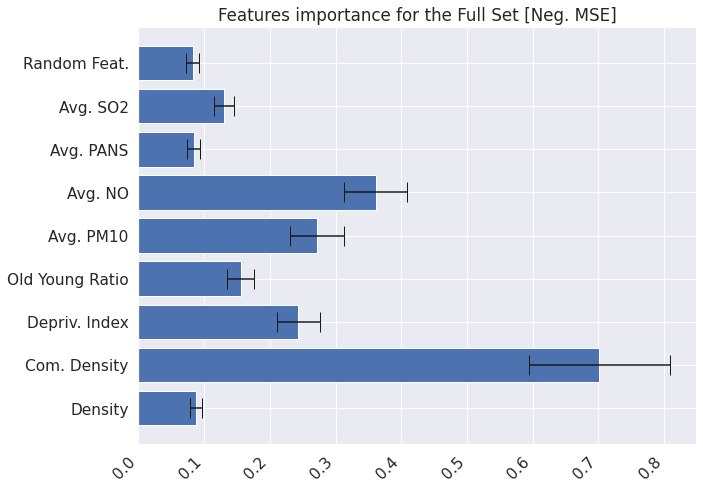

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.03994 +/- 0.00411
Feature:                   Com. Density, Score: 0.32085 +/- 0.04914
Feature:                  Depriv. Index, Score: 0.11148 +/- 0.01495
Feature:                Old Young Ratio, Score: 0.07136 +/- 0.00927
Feature:                      Avg. PM10, Score: 0.12458 +/- 0.01889
Feature:                        Avg. NO, Score: 0.16529 +/- 0.02198
Feature:                      Avg. PANS, Score: 0.03855 +/- 0.00472
Feature:                       Avg. SO2, Score: 0.05937 +/- 0.00692


<Figure size 432x288 with 0 Axes>

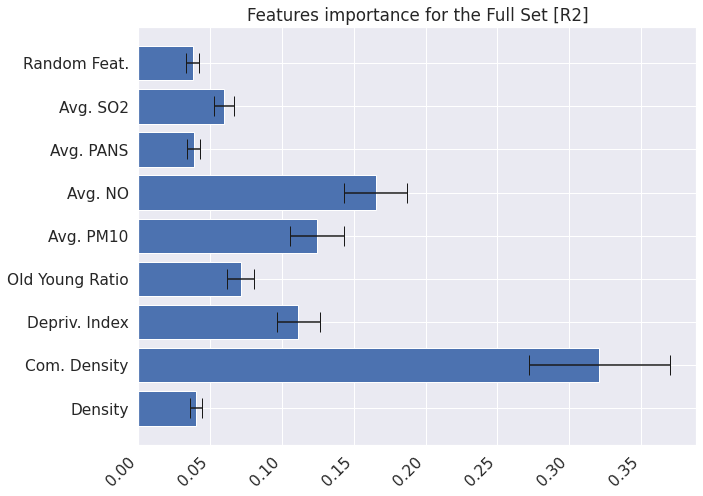

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.35581
                       R2:    0.94280


<Figure size 432x288 with 0 Axes>

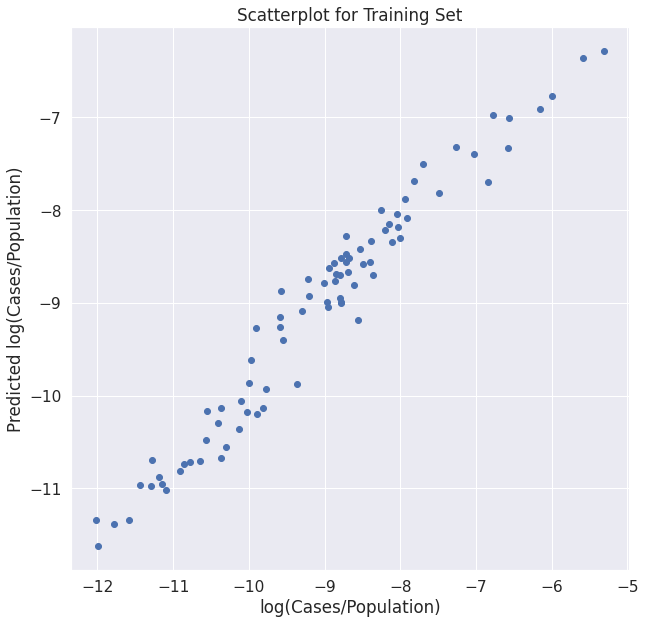

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.13748
                       R2:    0.17113


<Figure size 432x288 with 0 Axes>

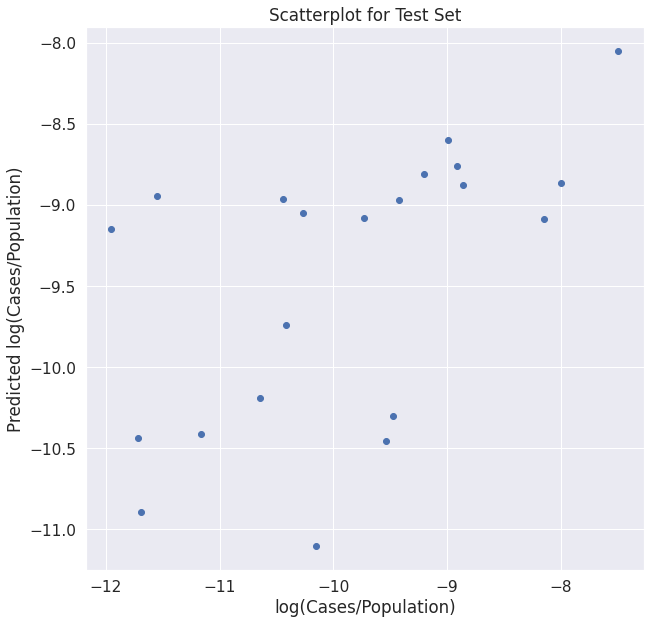

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00696 +/- 0.03771
Feature:                   Com. Density, Score: 0.41828 +/- 0.26976
Feature:                  Depriv. Index, Score: 0.07929 +/- 0.06888
Feature:                Old Young Ratio, Score: 0.02177 +/- 0.02356
Feature:                      Avg. PM10, Score: 0.04644 +/- 0.06680
Feature:                        Avg. NO, Score: 0.10309 +/- 0.08251
Feature:                       Avg. SO2, Score: 0.10021 +/- 0.05037


<Figure size 432x288 with 0 Axes>

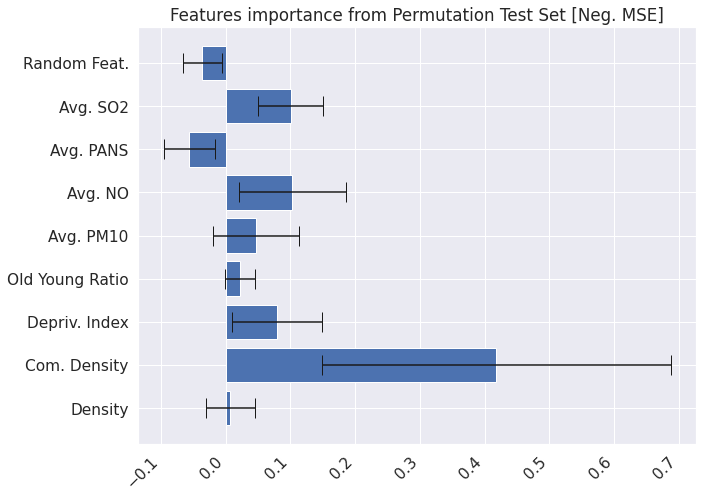

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.00446 +/- 0.02416
Feature:                   Com. Density, Score: 0.26796 +/- 0.17281
Feature:                  Depriv. Index, Score: 0.05079 +/- 0.04413
Feature:                Old Young Ratio, Score: 0.01395 +/- 0.01509
Feature:                      Avg. PM10, Score: 0.02975 +/- 0.04279
Feature:                        Avg. NO, Score: 0.06604 +/- 0.05286
Feature:                       Avg. SO2, Score: 0.06419 +/- 0.03227


<Figure size 432x288 with 0 Axes>

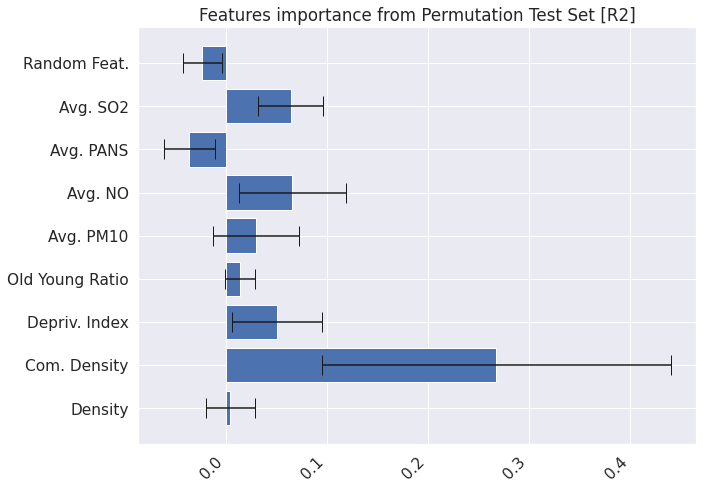

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.85429 +/- 0.10657
Feature:                  Depriv. Index, Score: 0.24307 +/- 0.03964
Feature:                Old Young Ratio, Score: 0.12452 +/- 0.01889
Feature:                      Avg. PM10, Score: 0.24720 +/- 0.03393
Feature:                        Avg. NO, Score: 0.25687 +/- 0.03370
Feature:                       Avg. SO2, Score: 0.11116 +/- 0.01138


<Figure size 432x288 with 0 Axes>

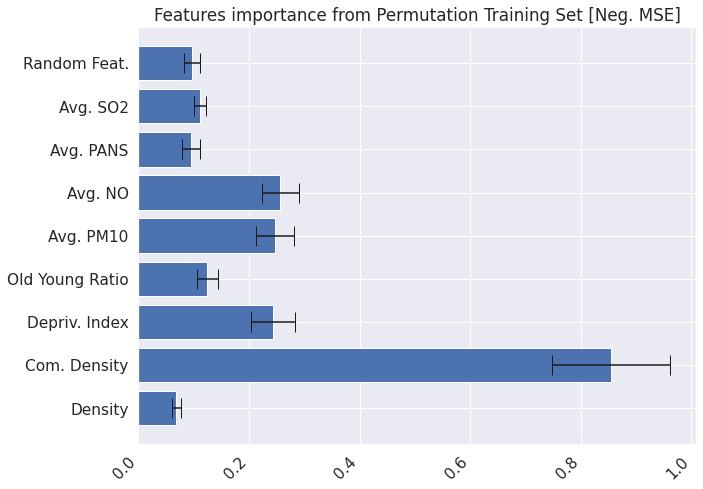

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.38594 +/- 0.04814
Feature:                  Depriv. Index, Score: 0.10981 +/- 0.01791
Feature:                Old Young Ratio, Score: 0.05625 +/- 0.00853
Feature:                      Avg. PM10, Score: 0.11168 +/- 0.01533
Feature:                        Avg. NO, Score: 0.11605 +/- 0.01522
Feature:                       Avg. SO2, Score: 0.05022 +/- 0.00514


<Figure size 432x288 with 0 Axes>

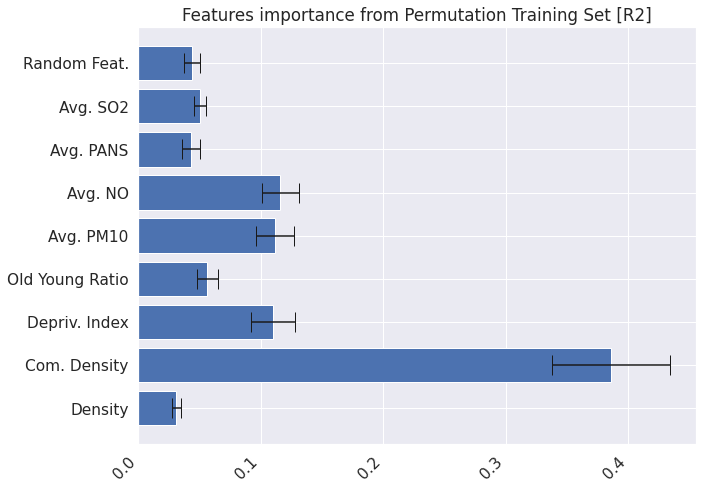

<Figure size 720x720 with 0 Axes>

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_traininingset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.39590  0.02590 
    Test set average RMSE:  1.05033  0.10544 

Prediction STD :    1.21521
True value STD :    1.47826
Difference in percentage:   17.79450

             Fullset RMSE:    0.38995
                       R2:    0.93041


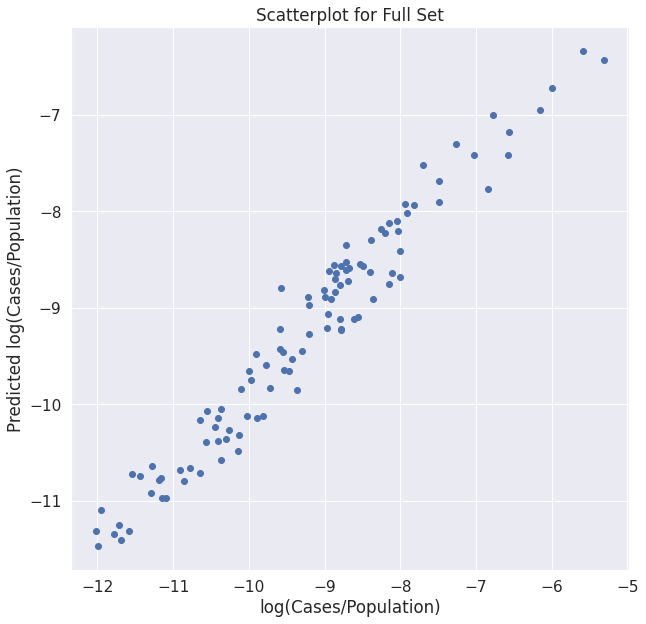

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.15014 +/- 0.01829
Feature:                  Depriv. Index, Score: 0.49711 +/- 0.06389
Feature:                Old Young Ratio, Score: 0.16818 +/- 0.01871
Feature:                      Avg. PM10, Score: 0.48075 +/- 0.06949
Feature:                        Avg. NO, Score: 0.53234 +/- 0.06900
Feature:                      Avg. PANS, Score: 0.13807 +/- 0.01507
Feature:                       Avg. SO2, Score: 0.18524 +/- 0.02157


<Figure size 432x288 with 0 Axes>

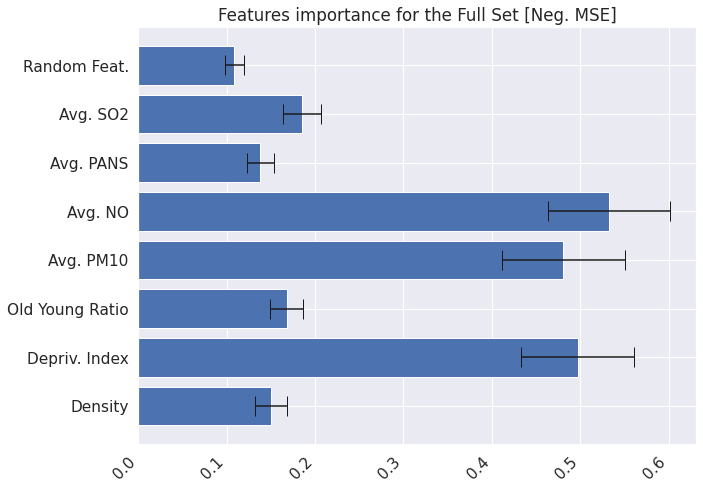

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.06871 +/- 0.00837
Feature:                  Depriv. Index, Score: 0.22749 +/- 0.02924
Feature:                Old Young Ratio, Score: 0.07696 +/- 0.00856
Feature:                      Avg. PM10, Score: 0.22000 +/- 0.03180
Feature:                        Avg. NO, Score: 0.24360 +/- 0.03158
Feature:                      Avg. PANS, Score: 0.06318 +/- 0.00690
Feature:                       Avg. SO2, Score: 0.08477 +/- 0.00987


<Figure size 432x288 with 0 Axes>

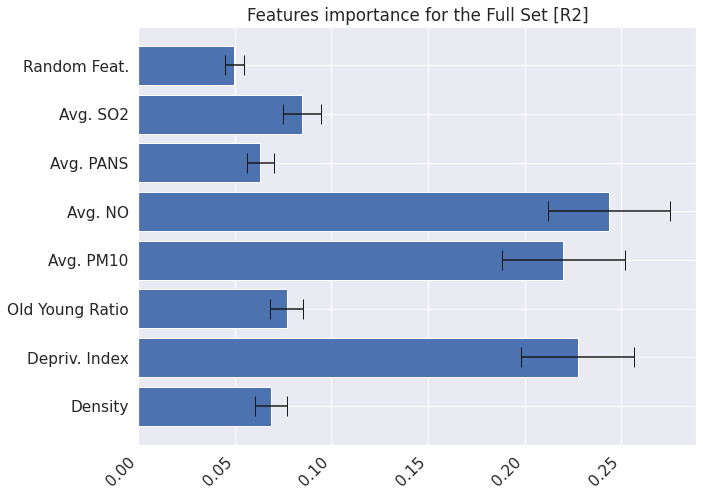

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.39089
                       R2:    0.93097


<Figure size 432x288 with 0 Axes>

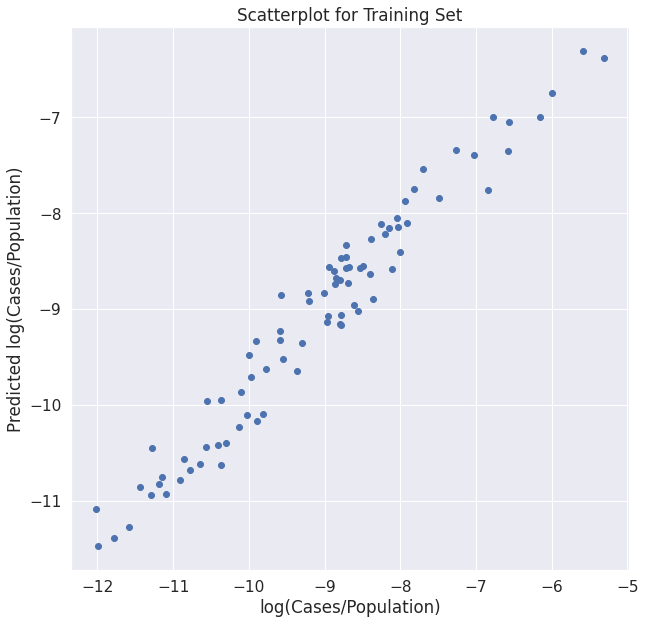

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.04832
                       R2:    0.29598


<Figure size 432x288 with 0 Axes>

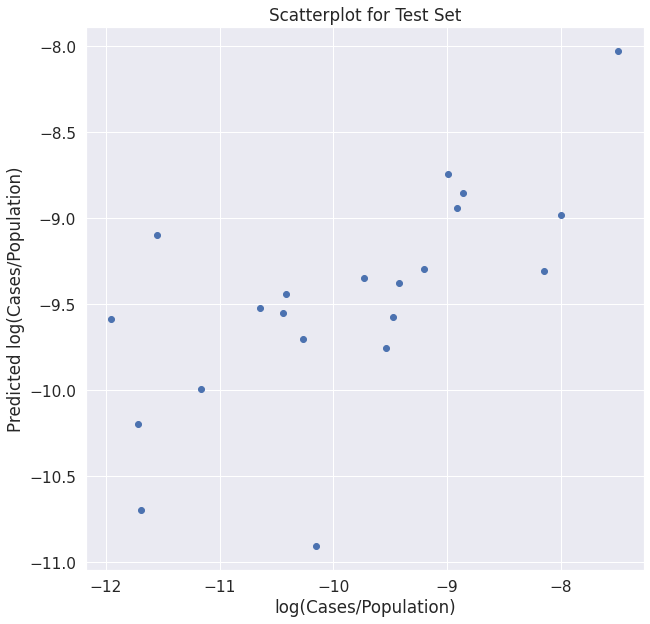

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.07138 +/- 0.04461
Feature:                  Depriv. Index, Score: 0.33087 +/- 0.15727
Feature:                Old Young Ratio, Score: 0.03272 +/- 0.04662
Feature:                      Avg. PM10, Score: 0.15199 +/- 0.09279
Feature:                        Avg. NO, Score: 0.27262 +/- 0.12176
Feature:                       Avg. SO2, Score: 0.09443 +/- 0.03729


<Figure size 432x288 with 0 Axes>

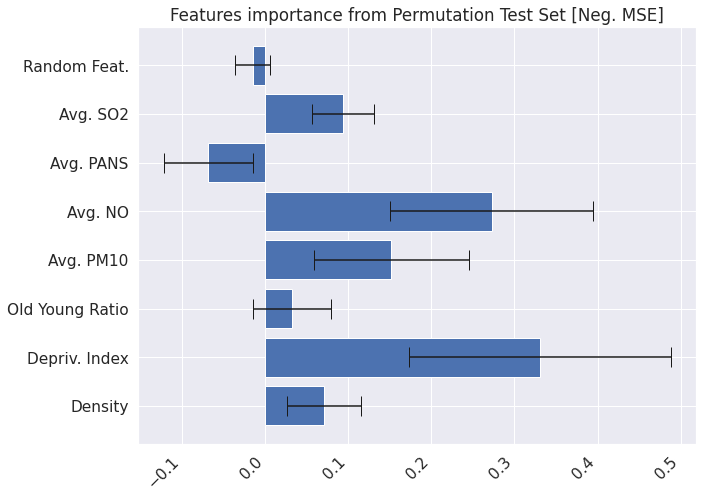

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.04573 +/- 0.02858
Feature:                  Depriv. Index, Score: 0.21196 +/- 0.10075
Feature:                Old Young Ratio, Score: 0.02096 +/- 0.02986
Feature:                      Avg. PM10, Score: 0.09737 +/- 0.05944
Feature:                        Avg. NO, Score: 0.17464 +/- 0.07800
Feature:                       Avg. SO2, Score: 0.06049 +/- 0.02389


<Figure size 432x288 with 0 Axes>

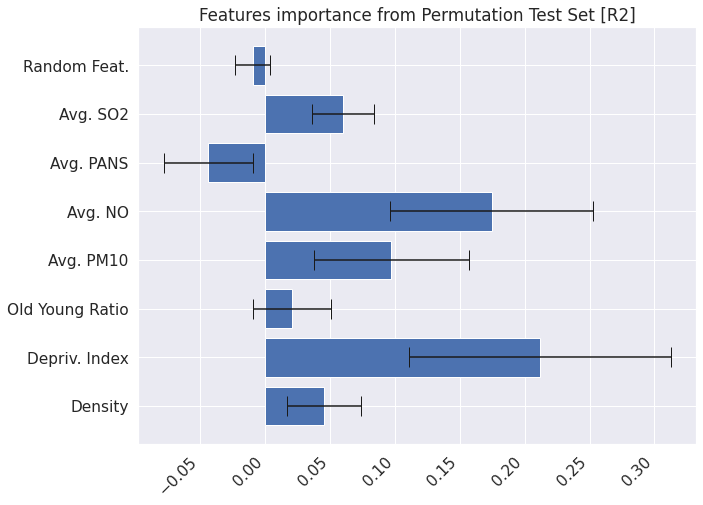

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.12509 +/- 0.01584
Feature:                  Depriv. Index, Score: 0.59914 +/- 0.08177
Feature:                Old Young Ratio, Score: 0.17005 +/- 0.02217
Feature:                      Avg. PM10, Score: 0.45383 +/- 0.06644
Feature:                        Avg. NO, Score: 0.43015 +/- 0.05992
Feature:                      Avg. PANS, Score: 0.15600 +/- 0.02611
Feature:                       Avg. SO2, Score: 0.14845 +/- 0.01645


<Figure size 432x288 with 0 Axes>

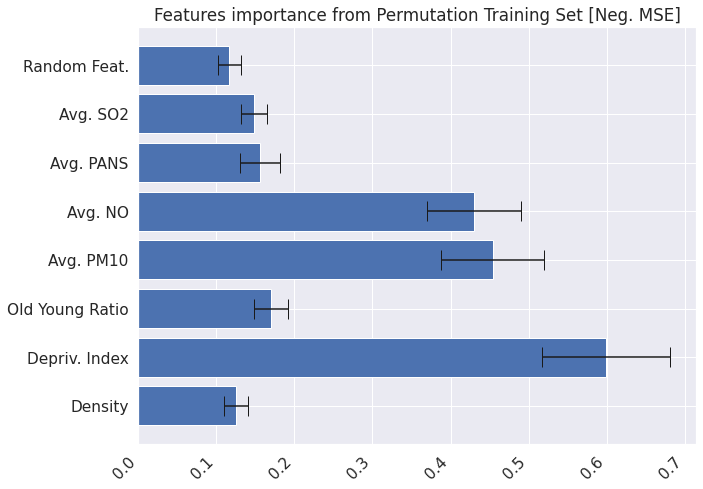

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.05651 +/- 0.00716
Feature:                  Depriv. Index, Score: 0.27067 +/- 0.03694
Feature:                Old Young Ratio, Score: 0.07682 +/- 0.01001
Feature:                      Avg. PM10, Score: 0.20502 +/- 0.03001
Feature:                        Avg. NO, Score: 0.19433 +/- 0.02707
Feature:                      Avg. PANS, Score: 0.07047 +/- 0.01180
Feature:                       Avg. SO2, Score: 0.06707 +/- 0.00743


<Figure size 432x288 with 0 Axes>

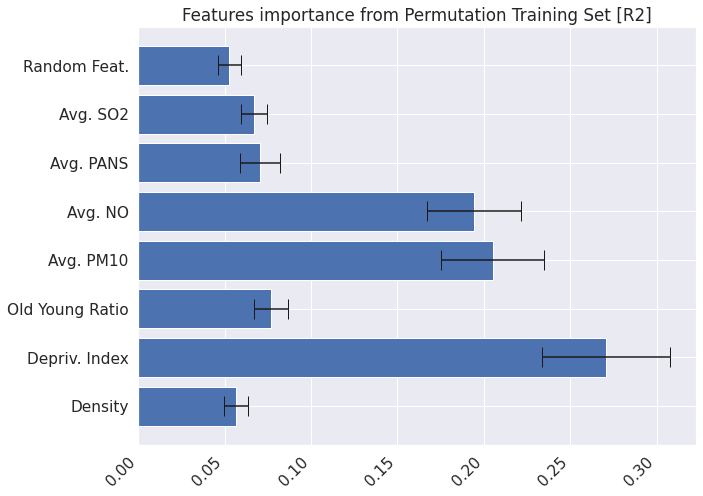

<Figure size 720x720 with 0 Axes>

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_trainset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_trainingset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Grid Search to optimize the RMSE on the Test Set 

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.65840  0.04015 
    Test set average RMSE:  0.90647  0.08412 

Prediction STD :    1.24510
True value STD :    1.47826
Difference in percentage:   15.77261

             Fullset RMSE:    0.61421
                       R2:    0.82736


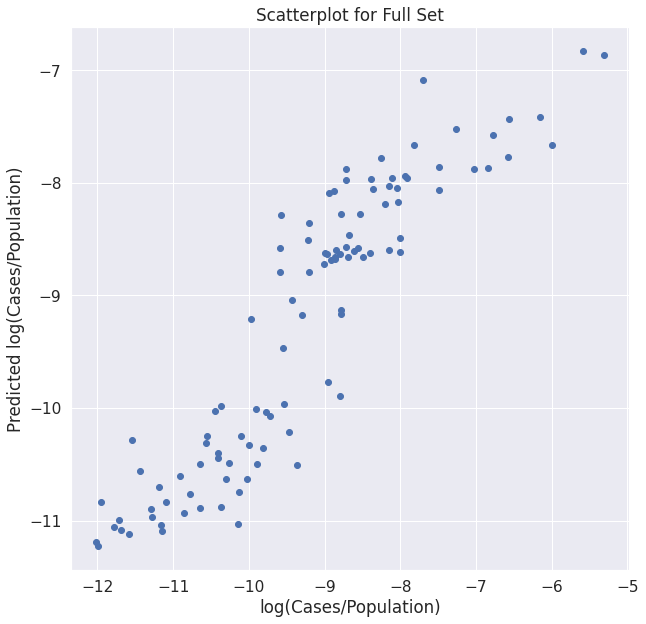

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                       Latitude, Score: 2.56163 +/- 0.32291
Feature:                Old Young Ratio, Score: 0.08290 +/- 0.02037
Feature:                      Avg. PM10, Score: 0.12577 +/- 0.02812
Feature:                        Avg. NO, Score: 0.10959 +/- 0.02226
Feature:                       Avg. SO2, Score: 0.04290 +/- 0.00952


<Figure size 432x288 with 0 Axes>

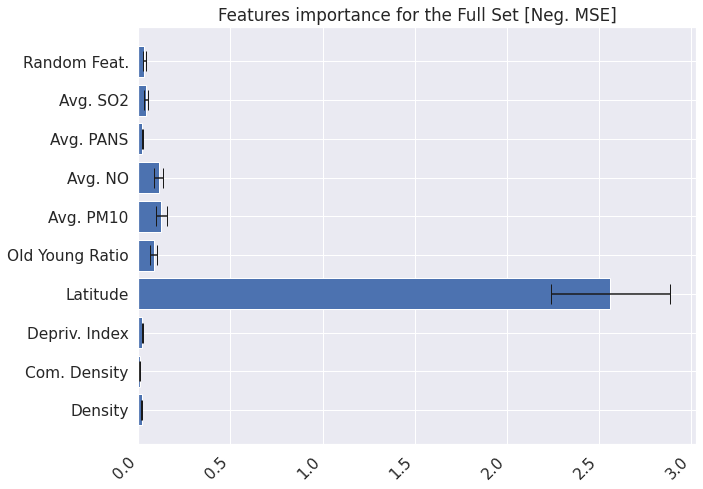

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                       Latitude, Score: 1.17224 +/- 0.14777
Feature:                Old Young Ratio, Score: 0.03794 +/- 0.00932
Feature:                      Avg. PM10, Score: 0.05755 +/- 0.01287
Feature:                        Avg. NO, Score: 0.05015 +/- 0.01019
Feature:                       Avg. SO2, Score: 0.01963 +/- 0.00436


<Figure size 432x288 with 0 Axes>

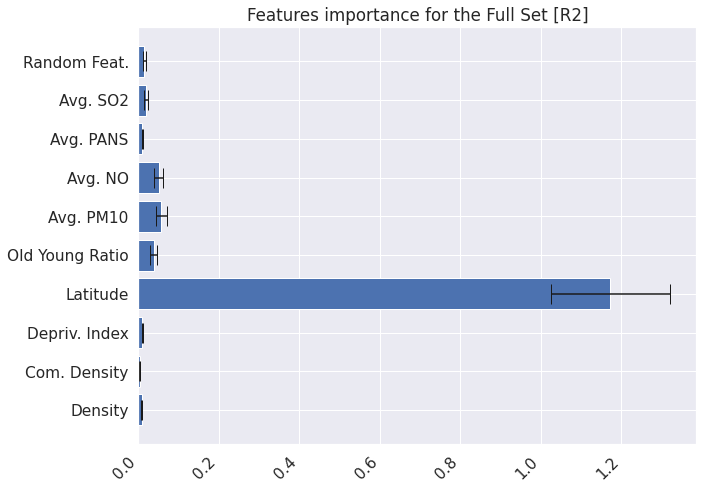

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.61437
                       R2:    0.82948


<Figure size 432x288 with 0 Axes>

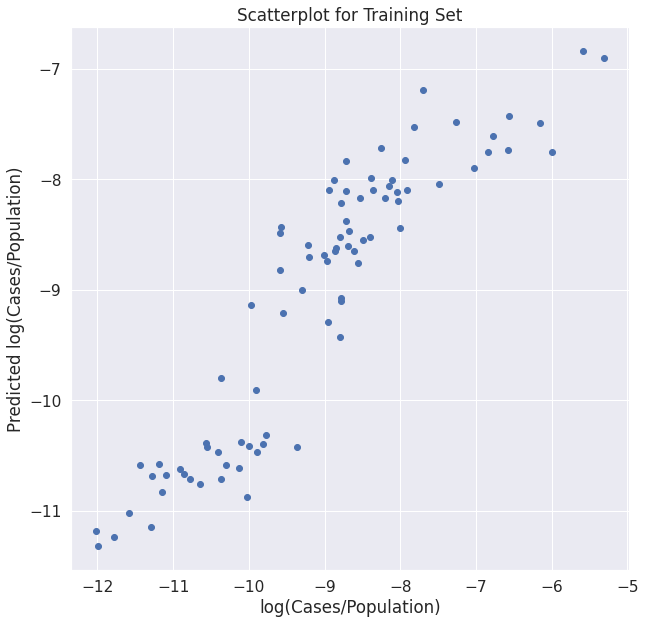

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.02246
                       R2:    0.33028


<Figure size 432x288 with 0 Axes>

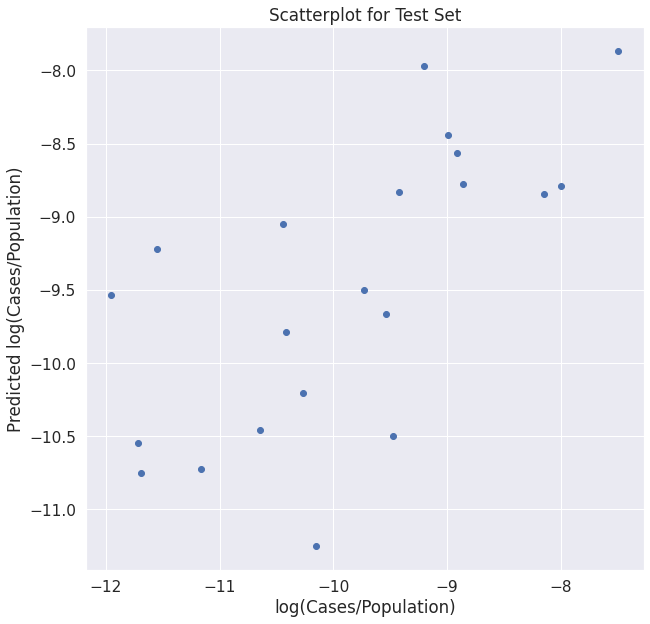

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                       Latitude, Score: 1.10582 +/- 0.41005
Feature:                Old Young Ratio, Score: 0.01063 +/- 0.02525
Feature:                      Avg. PM10, Score: 0.01957 +/- 0.04173
Feature:                        Avg. NO, Score: 0.02217 +/- 0.02515
Feature:                       Avg. SO2, Score: 0.02268 +/- 0.01331


<Figure size 432x288 with 0 Axes>

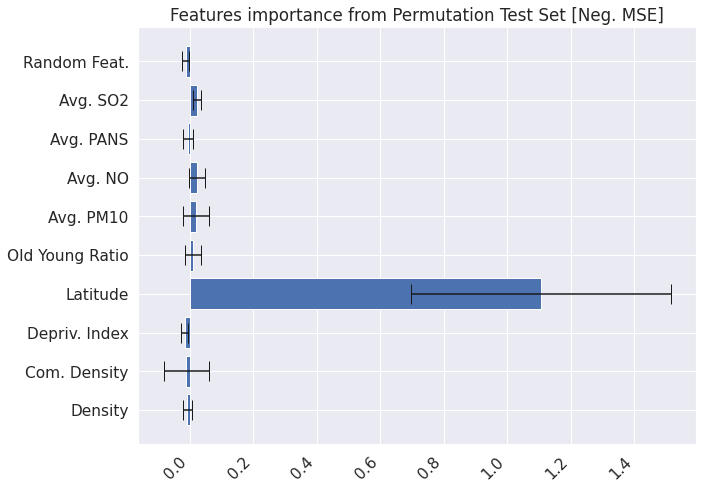

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                       Latitude, Score: 0.70840 +/- 0.26268
Feature:                Old Young Ratio, Score: 0.00681 +/- 0.01618
Feature:                      Avg. PM10, Score: 0.01254 +/- 0.02673
Feature:                        Avg. NO, Score: 0.01420 +/- 0.01611
Feature:                       Avg. SO2, Score: 0.01453 +/- 0.00853


<Figure size 432x288 with 0 Axes>

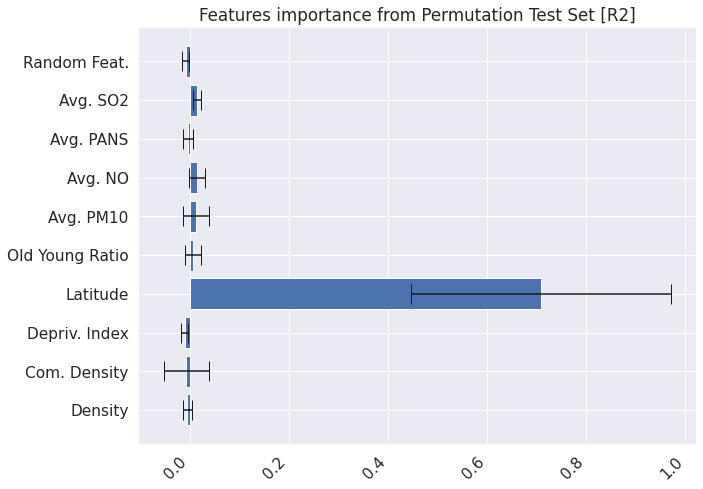

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.09017 +/- 0.02146
Feature:                  Depriv. Index, Score: 0.03615 +/- 0.00730
Feature:                       Latitude, Score: 2.03915 +/- 0.27263
Feature:                Old Young Ratio, Score: 0.08365 +/- 0.02445
Feature:                      Avg. PM10, Score: 0.16080 +/- 0.03385
Feature:                        Avg. NO, Score: 0.05573 +/- 0.01397
Feature:                       Avg. SO2, Score: 0.03458 +/- 0.00841


<Figure size 432x288 with 0 Axes>

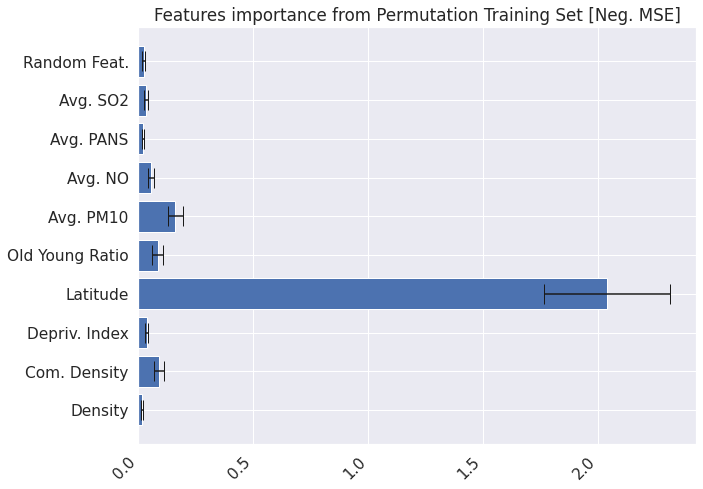

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.04074 +/- 0.00970
Feature:                  Depriv. Index, Score: 0.01633 +/- 0.00330
Feature:                       Latitude, Score: 0.92122 +/- 0.12316
Feature:                Old Young Ratio, Score: 0.03779 +/- 0.01104
Feature:                      Avg. PM10, Score: 0.07264 +/- 0.01529
Feature:                        Avg. NO, Score: 0.02518 +/- 0.00631
Feature:                       Avg. SO2, Score: 0.01562 +/- 0.00380


<Figure size 432x288 with 0 Axes>

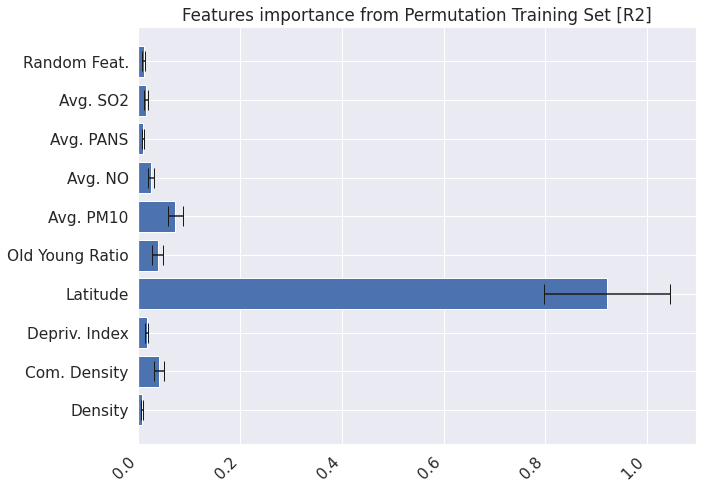

<Figure size 720x720 with 0 Axes>

In [14]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.45902  0.03119 
    Test set average RMSE:  1.03832  0.11269 

Prediction STD :    1.18335
True value STD :    1.47826
Difference in percentage:   19.94975

             Fullset RMSE:    0.52051
                       R2:    0.87602


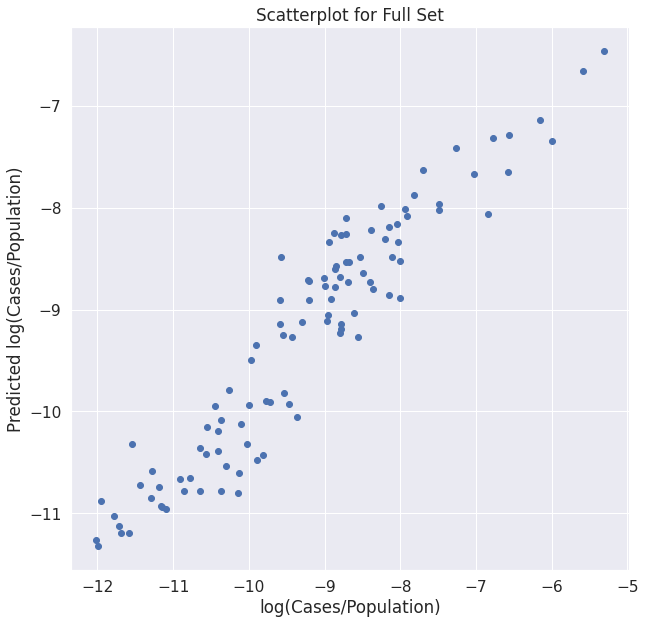

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.06498 +/- 0.00835
Feature:                   Com. Density, Score: 0.66642 +/- 0.10684
Feature:                  Depriv. Index, Score: 0.23063 +/- 0.03641
Feature:                Old Young Ratio, Score: 0.13758 +/- 0.02044
Feature:                      Avg. PM10, Score: 0.24431 +/- 0.04087
Feature:                        Avg. NO, Score: 0.33813 +/- 0.05037
Feature:                      Avg. PANS, Score: 0.06883 +/- 0.01015
Feature:                       Avg. SO2, Score: 0.11274 +/- 0.01529


<Figure size 432x288 with 0 Axes>

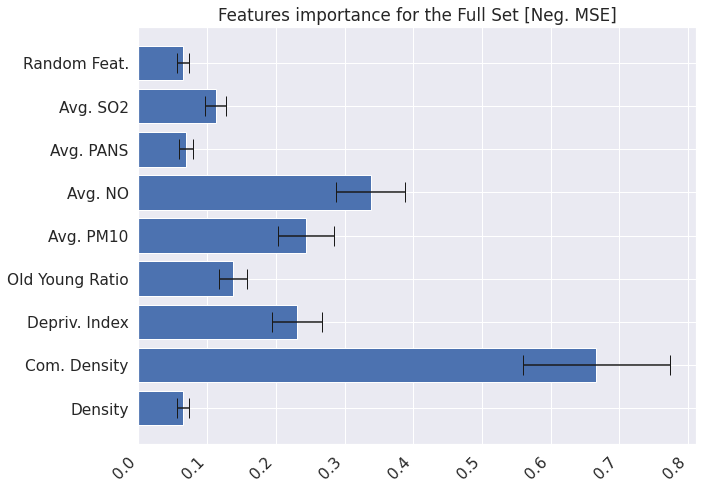

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.02973 +/- 0.00382
Feature:                   Com. Density, Score: 0.30496 +/- 0.04889
Feature:                  Depriv. Index, Score: 0.10554 +/- 0.01666
Feature:                Old Young Ratio, Score: 0.06296 +/- 0.00936
Feature:                      Avg. PM10, Score: 0.11180 +/- 0.01870
Feature:                        Avg. NO, Score: 0.15473 +/- 0.02305
Feature:                      Avg. PANS, Score: 0.03150 +/- 0.00464
Feature:                       Avg. SO2, Score: 0.05159 +/- 0.00700


<Figure size 432x288 with 0 Axes>

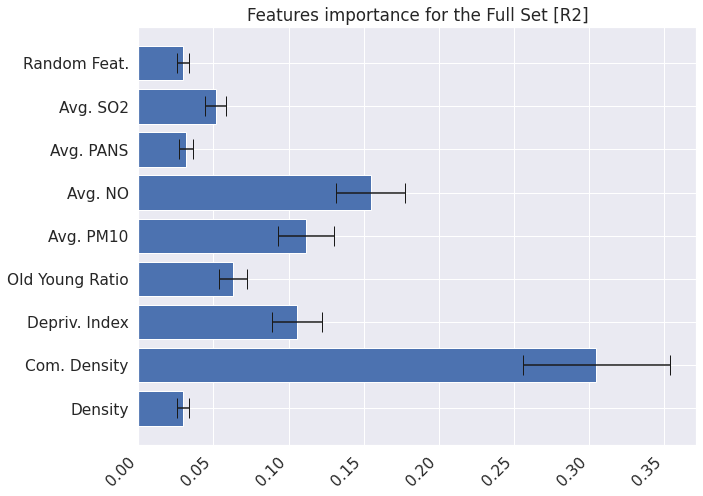

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.48363
                       R2:    0.89433


<Figure size 432x288 with 0 Axes>

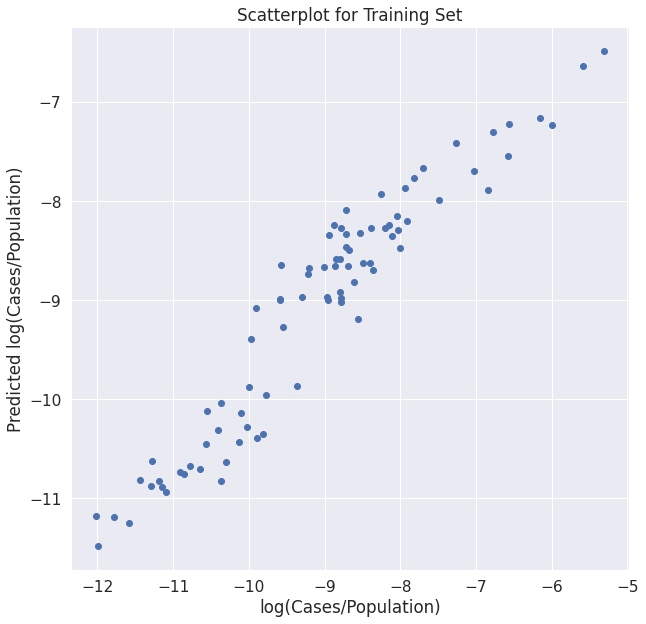

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.13984
                       R2:    0.16770


<Figure size 432x288 with 0 Axes>

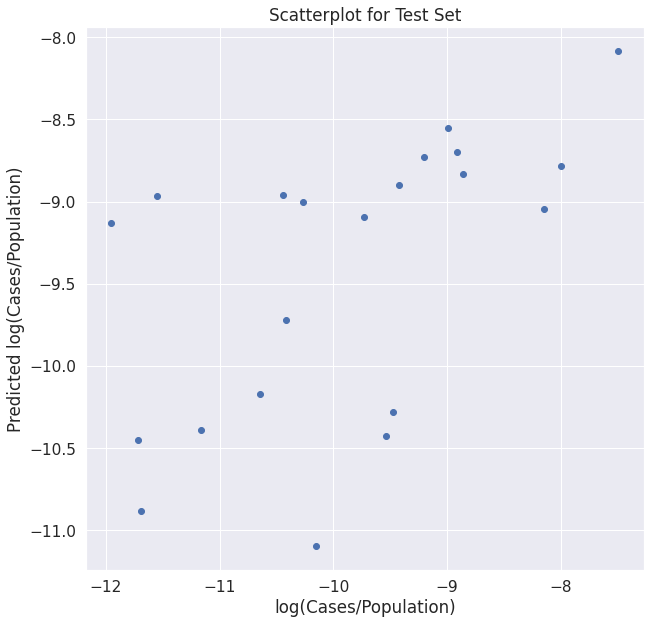

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.00871 +/- 0.03170
Feature:                   Com. Density, Score: 0.43313 +/- 0.27325
Feature:                  Depriv. Index, Score: 0.07009 +/- 0.07141
Feature:                Old Young Ratio, Score: 0.02210 +/- 0.02238
Feature:                      Avg. PM10, Score: 0.03901 +/- 0.05652
Feature:                        Avg. NO, Score: 0.10012 +/- 0.08050
Feature:                       Avg. SO2, Score: 0.08198 +/- 0.04458


<Figure size 432x288 with 0 Axes>

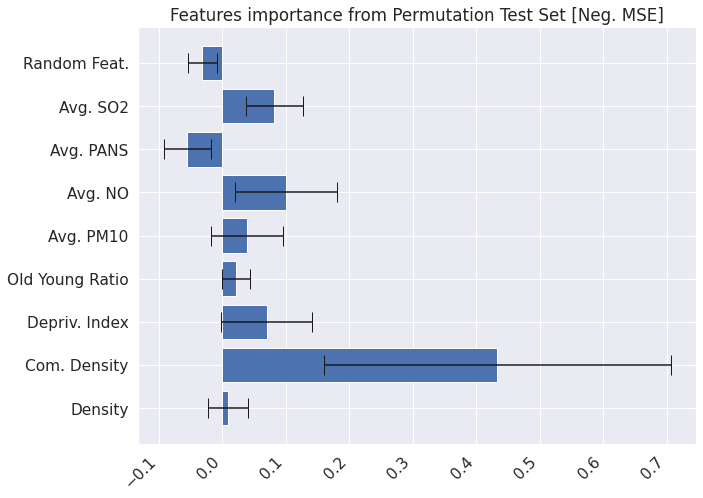

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.00558 +/- 0.02031
Feature:                   Com. Density, Score: 0.27747 +/- 0.17505
Feature:                  Depriv. Index, Score: 0.04490 +/- 0.04574
Feature:                Old Young Ratio, Score: 0.01416 +/- 0.01434
Feature:                      Avg. PM10, Score: 0.02499 +/- 0.03621
Feature:                        Avg. NO, Score: 0.06414 +/- 0.05157
Feature:                       Avg. SO2, Score: 0.05251 +/- 0.02856


<Figure size 432x288 with 0 Axes>

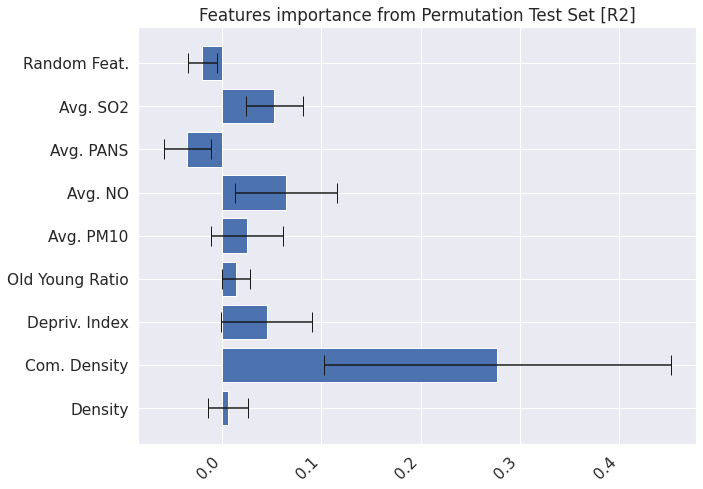

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.85269 +/- 0.10713
Feature:                  Depriv. Index, Score: 0.21466 +/- 0.03884
Feature:                Old Young Ratio, Score: 0.10912 +/- 0.01854
Feature:                      Avg. PM10, Score: 0.22466 +/- 0.03230
Feature:                        Avg. NO, Score: 0.25236 +/- 0.03594
Feature:                       Avg. SO2, Score: 0.10063 +/- 0.01171


<Figure size 432x288 with 0 Axes>

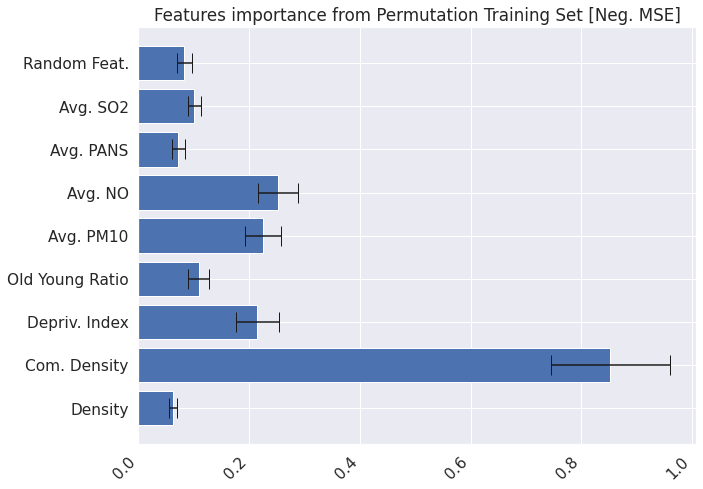

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.38522 +/- 0.04840
Feature:                  Depriv. Index, Score: 0.09698 +/- 0.01754
Feature:                Old Young Ratio, Score: 0.04930 +/- 0.00838
Feature:                      Avg. PM10, Score: 0.10149 +/- 0.01459
Feature:                        Avg. NO, Score: 0.11401 +/- 0.01624
Feature:                       Avg. SO2, Score: 0.04546 +/- 0.00529


<Figure size 432x288 with 0 Axes>

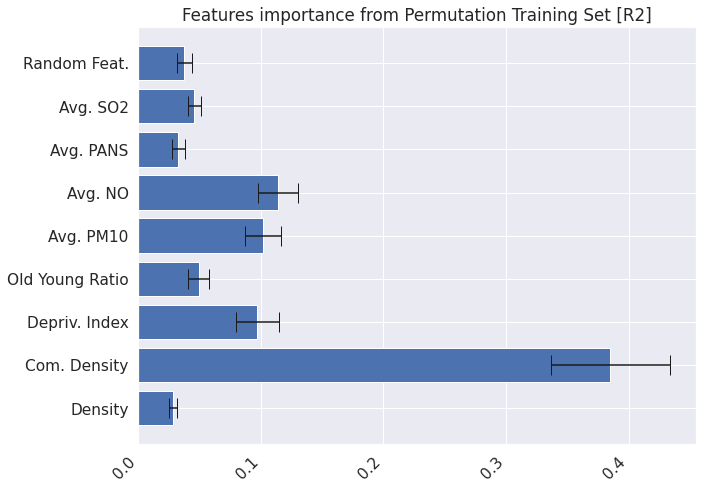

<Figure size 720x720 with 0 Axes>

In [15]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_diff, best_test_rmse, best_train_rmse = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_testset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.40041  0.02051 
    Test set average RMSE:  1.09563  0.08061 

Prediction STD :    1.20997
True value STD :    1.47826
Difference in percentage:   18.14920

             Fullset RMSE:    0.41084
                       R2:    0.92276


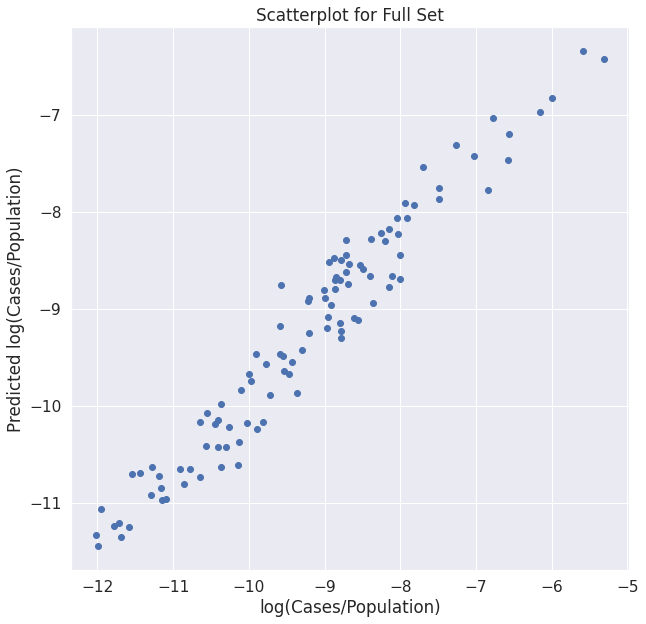

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.14592 +/- 0.01795
Feature:                  Depriv. Index, Score: 0.50741 +/- 0.06582
Feature:                Old Young Ratio, Score: 0.16805 +/- 0.01934
Feature:                      Avg. PM10, Score: 0.45381 +/- 0.06705
Feature:                        Avg. NO, Score: 0.52815 +/- 0.06823
Feature:                      Avg. PANS, Score: 0.13581 +/- 0.01482
Feature:                       Avg. SO2, Score: 0.17909 +/- 0.02117


<Figure size 432x288 with 0 Axes>

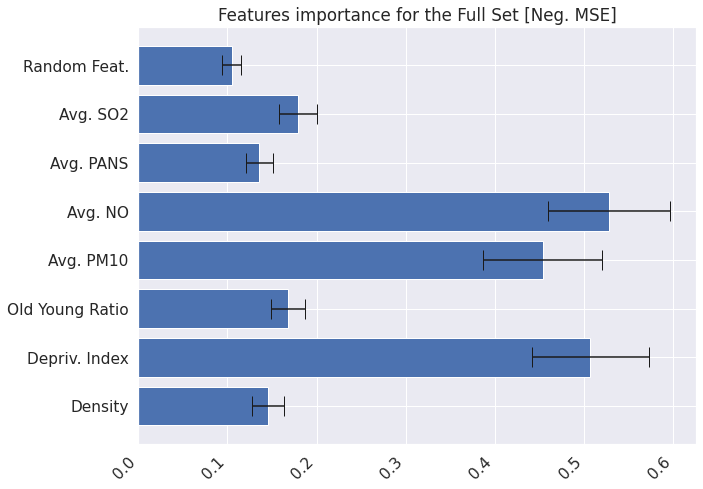

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.06677 +/- 0.00821
Feature:                  Depriv. Index, Score: 0.23220 +/- 0.03012
Feature:                Old Young Ratio, Score: 0.07690 +/- 0.00885
Feature:                      Avg. PM10, Score: 0.20767 +/- 0.03068
Feature:                        Avg. NO, Score: 0.24169 +/- 0.03122
Feature:                      Avg. PANS, Score: 0.06215 +/- 0.00678
Feature:                       Avg. SO2, Score: 0.08195 +/- 0.00969


<Figure size 432x288 with 0 Axes>

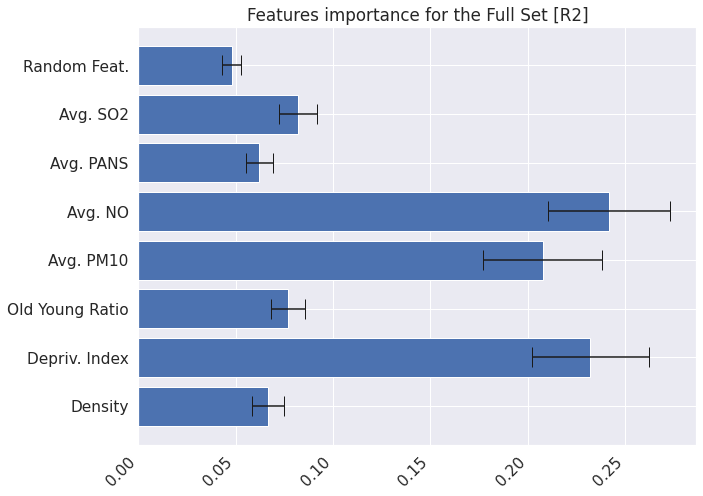

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.39627
                       R2:    0.92906


<Figure size 432x288 with 0 Axes>

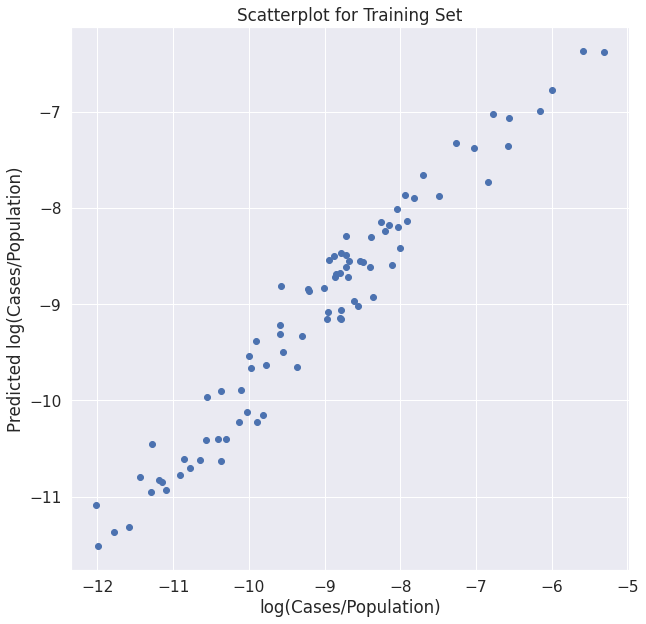

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.05838
                       R2:    0.28241


<Figure size 432x288 with 0 Axes>

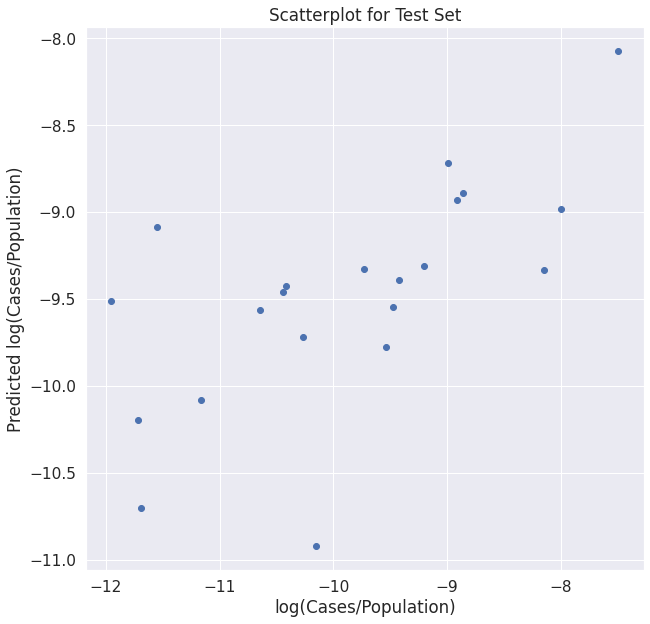

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.06856 +/- 0.04758
Feature:                  Depriv. Index, Score: 0.34335 +/- 0.15925
Feature:                Old Young Ratio, Score: 0.03329 +/- 0.04977
Feature:                      Avg. PM10, Score: 0.14223 +/- 0.09266
Feature:                        Avg. NO, Score: 0.26593 +/- 0.12590
Feature:                       Avg. SO2, Score: 0.08478 +/- 0.03541


<Figure size 432x288 with 0 Axes>

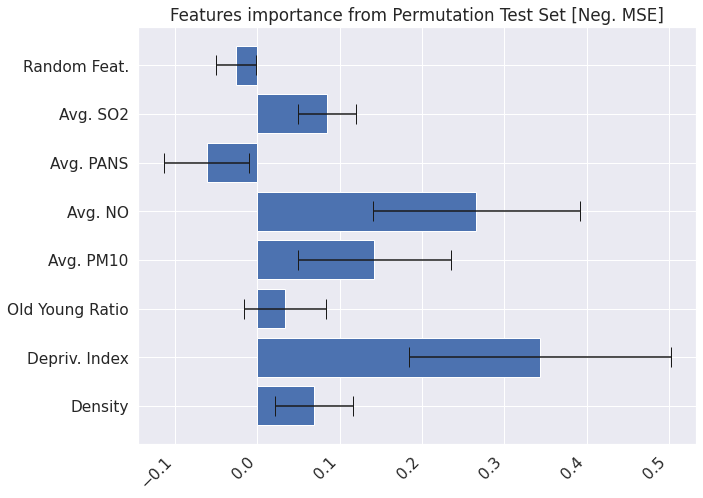

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                        Density, Score: 0.04392 +/- 0.03048
Feature:                  Depriv. Index, Score: 0.21995 +/- 0.10202
Feature:                Old Young Ratio, Score: 0.02133 +/- 0.03188
Feature:                      Avg. PM10, Score: 0.09111 +/- 0.05936
Feature:                        Avg. NO, Score: 0.17036 +/- 0.08066
Feature:                       Avg. SO2, Score: 0.05431 +/- 0.02269


<Figure size 432x288 with 0 Axes>

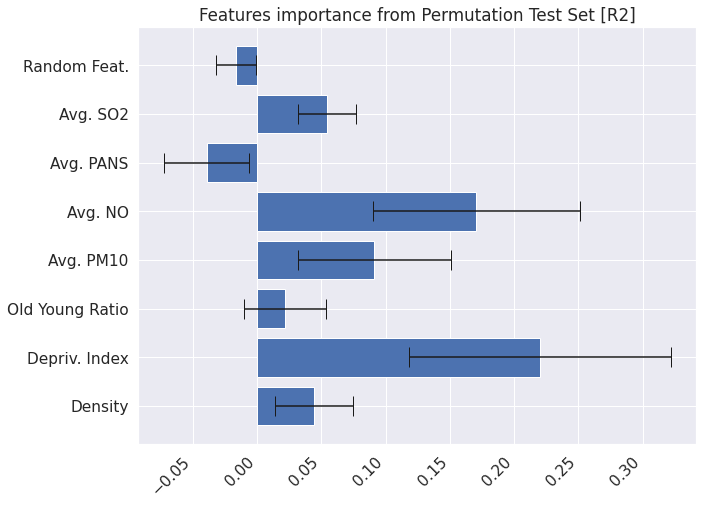

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.12007 +/- 0.01434
Feature:                  Depriv. Index, Score: 0.60225 +/- 0.08278
Feature:                Old Young Ratio, Score: 0.17624 +/- 0.02301
Feature:                      Avg. PM10, Score: 0.44750 +/- 0.06731
Feature:                        Avg. NO, Score: 0.44226 +/- 0.06223
Feature:                      Avg. PANS, Score: 0.15227 +/- 0.02495
Feature:                       Avg. SO2, Score: 0.14883 +/- 0.01696


<Figure size 432x288 with 0 Axes>

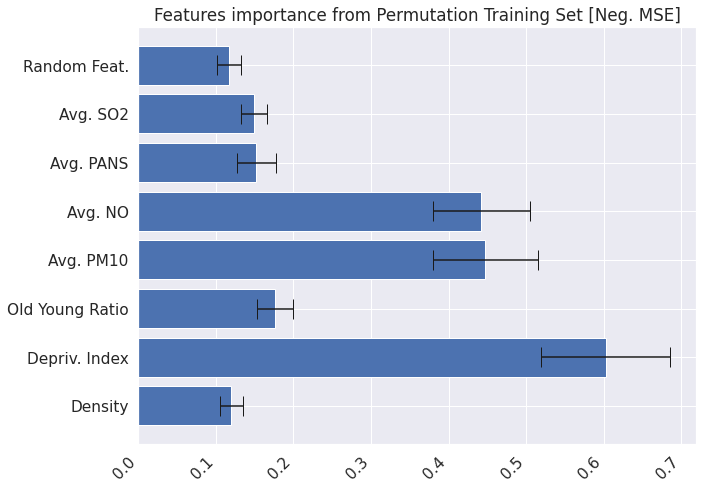

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.05424 +/- 0.00648
Feature:                  Depriv. Index, Score: 0.27208 +/- 0.03740
Feature:                Old Young Ratio, Score: 0.07962 +/- 0.01039
Feature:                      Avg. PM10, Score: 0.20217 +/- 0.03041
Feature:                        Avg. NO, Score: 0.19980 +/- 0.02812
Feature:                      Avg. PANS, Score: 0.06879 +/- 0.01127
Feature:                       Avg. SO2, Score: 0.06724 +/- 0.00766


<Figure size 432x288 with 0 Axes>

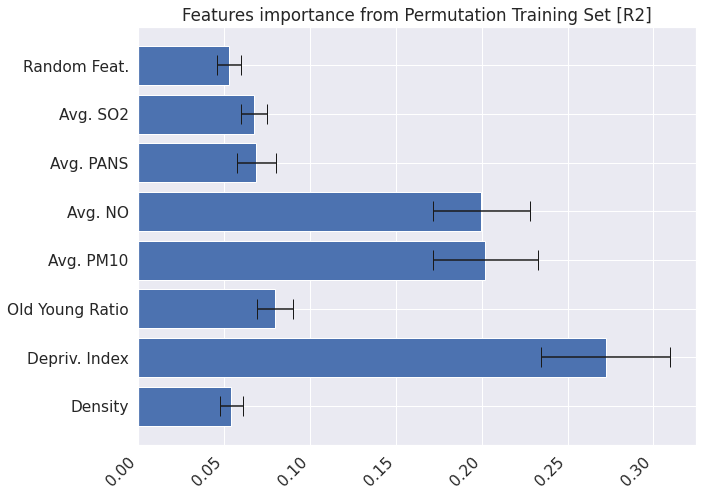

<Figure size 720x720 with 0 Axes>

In [16]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_testset (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_testset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)